# Mid Price Prediction & Market Making

Jack Mansfield      12407052

Pranav Devarakonda  12338043

## What is Market Making?

Market making is a trading strategy that involves continuously buying and selling securities to provide liquidity to the market. Market makers profit from the spread between the buy (bid) and sell (ask) prices. By fulfilling buy and sell orders, market makers facilitate smoother trading and more liquid markets, earning small profits on the spread between buying and selling prices.

## Goal of the Strategy

In this document we test a market making strategy applied to a major cryptocurrency: Ethereum/US Dollar (ETH/USD) and incoperate data from another: Ethereum/Bitcoin (ETH/BTC). 

The cornerstone of our strategy is the concept of a theoretical market value, around which we aim to conduct our market making activities. Rather than merely reacting to market movements, we proactively predict the percentage change in this theoretical market value (referred to as MKT_Theo). Predicting these changes allows us to adjust our target bid and ask prices around which we make the market, enabling us to anticipate market movements and adjust our bids and asks accordingly to capture profit from the spread.

## Features and Model

To predict the percentage change in MKT_Theo, we leverage several key market features:

- **Volume**: The total amount of asset traded within a specific time frame.
- **Trade Flow**: The net amount of asset bought or sold, indicating market direction.
- **Share Imbalance**: The ratio of demand to supply in the market, derived from order book data.
- **Cross Volume**: The total amount of asset traded within a specific time frame from the correlated asset, Ethereum/Bitcoin (ETH/BTC)
- **Cross Trade Flow**: The net amount of asset bought or sold, indicating market direction from the correlated asset, Ethereum/Bitcoin (ETH/BTC)


These features, extracted from historical trading and order book data, feed into a regression model. This model is tasked with forecasting the short-term percentage change in our MKT_Theo, allowing us to adapt our market making strategy dynamically to the predicted market conditions.

## Predictive Modeling

Develop a regression model to forecast short-term changes in the market's theoretical price (MKT_Theo). This involves predicting the expected change in MKT_Theo based on the engineered features.

## Trade Execution Logic

- **Theoretical Price Adjustment**: Adjust the theoretical price (MKT_Theo) based on the regression model's predictions and inventory considerations to generate an adjusted theoretical price (ADJtheo).
- **Market Condition Response (MCR)**: Implement a dynamic Market Condition Response to adjust trading behavior based on the current inventory level, encouraging inventory normalization.
- **Edge Calculation**: Determine the trading edge by comparing the actual trade prices against the ADJtheo. Trades are executed only when a predefined minimum edge is surpassed.
- **Trade Sizing**: Dynamically size trades based on the calculated edge, with larger sizes for trades with higher edges, while respecting a participation rate to manage impact.

## Backtesting and Parameter Tuning

Rigorously backtest the strategy on historical data, adjusting hyperparameters through grid search techniques to optimize performance.

## Performance Analysis

Evaluate the strategy's performance using sharp ratio.

By systematically analyzing market data, predicting price movements, and executing trades based on these predictions, this strategy aims to capitalize on market inefficiencies and generate profit through market making.


### Import dependencies and init globals

In [1]:
%reload_ext autoreload

In [2]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
from pandas.tseries.holiday import USFederalHolidayCalendar
from sklearn.preprocessing import StandardScaler
import pandas_market_calendars as mcal
import numpy as np
import scipy as sp
from scipy.stats import zscore

import itertools


import math
from math import floor
import functools
import seaborn as sns
import h5py
import copy
import openpyxl
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error



from plotnine import ggplot, aes, geom_line, geom_hline, labs, theme, element_text, geom_area, scale_fill_manual, geom_bar

import os
from datetime import datetime
from datetime import datetime
from dateutil.relativedelta import relativedelta

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


from enum import Enum

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)



from Utilities import *
import importlib


# 1) Data

The first step in our algorithm is to read in the data into dataframes. We then convert the timestamps in our data into datetimes so that they will be easier to use and read going forward. 

## 1.1) Parse Raw Data

In [3]:
# Specify file Paths
file_path_1 = r"C:\Users\jackm\OneDrive\Desktop\MSFM\QTS\Final_Project\QTS_Final_Project\Data\book_narrow_ETH-USD_2021.delim"  # Update this to the actual path of your file
file_path_2 = r"C:\Users\jackm\OneDrive\Desktop\MSFM\QTS\Final_Project\QTS_Final_Project\Data\trades_narrow_ETH-USD_2021.delim"  # Update this to the actual path of your file

# Read the data into a DataFrame, specifying the tab delimiter
ETH_USD_book_raw = pd.read_csv(file_path_1,delimiter = '\t')
ETH_USD_trades_raw = pd.read_csv(file_path_2,delimiter = '\t')

# Convert timestamps to datetime format
ETH_USD_book_raw['timestamp_utc_nanoseconds'] = pd.to_datetime(ETH_USD_book_raw['timestamp_utc_nanoseconds'], unit='ns')
ETH_USD_book_raw['received_utc_nanoseconds'] = pd.to_datetime(ETH_USD_book_raw['received_utc_nanoseconds'], unit='ns')
ETH_USD_trades_raw['timestamp_utc_nanoseconds'] = pd.to_datetime(ETH_USD_trades_raw['timestamp_utc_nanoseconds'], unit='ns')
ETH_USD_trades_raw['received_utc_nanoseconds'] = pd.to_datetime(ETH_USD_trades_raw['received_utc_nanoseconds'], unit='ns')

# Display the first few rows to verify
display(ETH_USD_book_raw.head())
display(ETH_USD_trades_raw.head())


,Ask1PriceMillionths,Bid1PriceMillionths,Ask1SizeBillionths,Bid1SizeBillionths,Ask2PriceMillionths,Bid2PriceMillionths,Ask2SizeBillionths,Bid2SizeBillionths,received_utc_nanoseconds,timestamp_utc_nanoseconds,Mid
0,2109000000,2108990000,14095270200,9377656280,2109030000,2108980000,6453440000,3000000000,2021-04-10 21:28:56.259045800,2021-04-10 21:28:54.547039,2.108995e+09
1,2109000000,2108990000,14095270200,9377656280,2109030000,2108970000,6453440000,2010700000,2021-04-10 21:28:56.260697100,2021-04-10 21:28:54.563411,2.108995e+09
2,2109000000,2108990000,14059061350,9377656280,2109030000,2108970000,6453440000,2010700000,2021-04-10 21:28:56.280332000,2021-04-10 21:28:54.797956,2.108995e+09
3,2109000000,2108990000,13559561350,9377656280,2109030000,2108970000,6453440000,2010700000,2021-04-10 21:28:56.304898000,2021-04-10 21:28:55.123831,2.108995e+09
4,2109000000,2108990000,13559561350,9277577810,2109030000,2108970000,6453440000,2010700000,2021-04-10 21:28:56.318234200,2021-04-10 21:28:55.368753,2.108995e+09


,received_utc_nanoseconds,timestamp_utc_nanoseconds,PriceMillionths,SizeBillionths,Side
0,2021-04-10 21:28:56.259046,2021-04-10 21:28:54.547039,2109000000,499500000,1
1,2021-04-10 21:28:56.280332,2021-04-10 21:28:54.797956,2109000000,36208850,1
2,2021-04-10 21:28:56.304898,2021-04-10 21:28:55.123831,2109000000,499500000,1
3,2021-04-10 21:28:56.346044,2021-04-10 21:28:55.704667,2109000000,499400000,1
4,2021-04-10 21:28:56.376357,2021-04-10 21:28:56.302068,2109000000,499400000,1


In [4]:

# Specify file Paths
file_path_1 = r"C:\Users\jackm\OneDrive\Desktop\MSFM\QTS\Final_Project\QTS_Final_Project\Data\book_narrow_ETH-BTC_2021.delim"  # Update this to the actual path of your file
file_path_2 = r"C:\Users\jackm\OneDrive\Desktop\MSFM\QTS\Final_Project\QTS_Final_Project\Data\trades_narrow_ETH-BTC_2021.delim"  # Update this to the actual path of your file

# Read the data into a DataFrame
ETH_BTC_book_raw = pd.read_csv(file_path_1,delimiter = '\t')
ETH_BTC_trades_raw = pd.read_csv(file_path_2,delimiter = '\t')


# Convert timestamps to datetime format
ETH_BTC_book_raw['timestamp_utc_nanoseconds'] = pd.to_datetime(ETH_BTC_book_raw['timestamp_utc_nanoseconds'], unit='ns')
ETH_BTC_book_raw['received_utc_nanoseconds'] = pd.to_datetime(ETH_BTC_book_raw['received_utc_nanoseconds'], unit='ns')
ETH_BTC_trades_raw['timestamp_utc_nanoseconds'] = pd.to_datetime(ETH_BTC_trades_raw['timestamp_utc_nanoseconds'], unit='ns')
ETH_BTC_trades_raw['received_utc_nanoseconds'] = pd.to_datetime(ETH_BTC_trades_raw['received_utc_nanoseconds'], unit='ns')

# Display the first few rows to verify
display(ETH_BTC_book_raw.head())
display(ETH_BTC_trades_raw.head())


,Ask1PriceMillionths,Bid1PriceMillionths,Ask1SizeBillionths,Bid1SizeBillionths,Ask2PriceMillionths,Bid2PriceMillionths,Ask2SizeBillionths,Bid2SizeBillionths,received_utc_nanoseconds,timestamp_utc_nanoseconds,Mid
0,35700,35690,11872084060,32957203990,35710,35680,31032423370,45284575470,2021-04-10 21:28:56.351018,2021-04-10 21:28:55.799659,35695.0
1,35700,35690,11872084060,32957203990,35710,35680,30332423370,45284575470,2021-04-10 21:28:56.378911,2021-04-10 21:28:56.388074,35695.0
2,35700,35690,11872084060,32957203990,35710,35680,22332423370,45284575470,2021-04-10 21:28:57.062420,2021-04-10 21:28:57.078119,35695.0
3,35700,35690,11872084060,32957203990,35710,35680,22332423370,45284575470,2021-04-10 21:28:57.062989,2021-04-10 21:28:57.082698,35695.0
4,35700,35690,11872084060,32956203990,35710,35680,22332423370,45284575470,2021-04-10 21:28:57.140737,2021-04-10 21:28:57.157544,35695.0


,received_utc_nanoseconds,timestamp_utc_nanoseconds,PriceMillionths,SizeBillionths,Side
0,2021-04-10 21:28:57.140737,2021-04-10 21:28:57.157544,35690,1000000,-1
1,2021-04-10 21:28:57.851379,2021-04-10 21:28:57.864544,35700,29801980,2
2,2021-04-10 21:29:03.777062,2021-04-10 21:29:03.793909,35700,4641070,1
3,2021-04-10 21:29:15.038792,2021-04-10 21:29:15.053606,35710,1000000,1
4,2021-04-10 21:29:15.039208,2021-04-10 21:29:15.053606,35720,231355690,1


## 1.2) Data Cleaning 

The next step in our algorithm is to clean the data; we convert price and size from units of millionths and billionths to units of 1. We also remove duplicates, and change our size column to represent which side the transaction was (positive for buys and negative for sells). 


In [5]:
# Save checkpoint for ETH_USD pair
ETH_USD_book = ETH_USD_book_raw.copy()
ETH_USD_trades = ETH_USD_trades_raw.copy()

# Save checkpoint for ETH_BTC pair
ETH_BTC_book = ETH_BTC_book_raw.copy()
ETH_BTC_trades = ETH_BTC_trades_raw.copy()


#### Helper Functions

#### 1.2.1) Clean Order Book Data

In [6]:
# Drop unnecessary Columns for all pairs
ETH_USD_book = ETH_USD_book.drop(['received_utc_nanoseconds'], axis=1)
ETH_BTC_book = ETH_BTC_book.drop(['received_utc_nanoseconds'], axis=1)

# Rescale price data for all pairs
ETH_USD_book['Ask1PriceMillionths'] = ETH_USD_book['Ask1PriceMillionths'] / 1000000.0
ETH_BTC_book['Ask1PriceMillionths'] = ETH_BTC_book['Ask1PriceMillionths'] / 1000000.0

ETH_USD_book['Bid1PriceMillionths'] = ETH_USD_book['Bid1PriceMillionths'] / 1000000.0
ETH_BTC_book['Bid1PriceMillionths'] = ETH_BTC_book['Bid1PriceMillionths'] / 1000000.0

ETH_USD_book['Ask2PriceMillionths'] = ETH_USD_book['Ask2PriceMillionths'] / 1000000.0
ETH_BTC_book['Ask2PriceMillionths'] = ETH_BTC_book['Ask2PriceMillionths'] / 1000000.0

ETH_USD_book['Bid2PriceMillionths'] = ETH_USD_book['Bid2PriceMillionths'] / 1000000.0
ETH_BTC_book['Bid2PriceMillionths'] = ETH_BTC_book['Bid2PriceMillionths'] / 1000000.0

# Rescale size data for all pairs
ETH_USD_book['Ask1SizeBillionths'] = ETH_USD_book['Ask1SizeBillionths'] / 1000000000.0
ETH_BTC_book['Ask1SizeBillionths'] = ETH_BTC_book['Ask1SizeBillionths'] / 1000000000.0

ETH_USD_book['Bid1SizeBillionths'] = ETH_USD_book['Bid1SizeBillionths'] / 1000000000.0
ETH_BTC_book['Bid1SizeBillionths'] = ETH_BTC_book['Bid1SizeBillionths'] / 1000000000.0

ETH_USD_book['Ask2SizeBillionths'] = ETH_USD_book['Ask2SizeBillionths'] / 1000000000.0
ETH_BTC_book['Ask2SizeBillionths'] = ETH_BTC_book['Ask2SizeBillionths'] / 1000000000.0

ETH_USD_book['Bid2SizeBillionths'] = ETH_USD_book['Bid2SizeBillionths'] / 1000000000.0
ETH_BTC_book['Bid2SizeBillionths'] = ETH_BTC_book['Bid2SizeBillionths'] / 1000000000.0


# Rename columns for all pairs 
ETH_USD_book = ETH_USD_book.rename(columns={'timestamp_utc_nanoseconds': 'time', 'Mid': 'mid',  'Ask1PriceMillionths': 'ask_price_1', 'Bid1PriceMillionths': 'bid_price_1', 'Ask1SizeBillionths': 'ask_size_1', 'Bid1SizeBillionths':'bid_size_1','Ask2PriceMillionths': 'ask_price_2', 'Bid2PriceMillionths': 'bid_price_2', 'Ask2SizeBillionths': 'ask_size_2', 'Bid2SizeBillionths':'bid_size_2'})
ETH_BTC_book = ETH_BTC_book.rename(columns={'timestamp_utc_nanoseconds': 'time', 'Mid': 'mid',  'Ask1PriceMillionths': 'ask_price_1', 'Bid1PriceMillionths': 'bid_price_1', 'Ask1SizeBillionths': 'ask_size_1', 'Bid1SizeBillionths':'bid_size_1','Ask2PriceMillionths': 'ask_price_2', 'Bid2PriceMillionths': 'bid_price_2', 'Ask2SizeBillionths': 'ask_size_2', 'Bid2SizeBillionths':'bid_size_2'})

ETH_USD_book['mid'] =  (ETH_USD_book['bid_price_1'] + ETH_USD_book['ask_price_1'] ) / 2.0
ETH_BTC_book['mid'] =  (ETH_BTC_book['bid_price_1'] + ETH_BTC_book['ask_price_1'] ) / 2.0


# Set indices and sort for all pairs
ETH_USD_book = process_and_set_index(ETH_USD_book, 'time')
ETH_BTC_book = process_and_set_index(ETH_BTC_book, 'time')

# Check dataframe integrity for all pairs
check_dataframe_integrity(ETH_USD_book)
check_dataframe_integrity(ETH_BTC_book)

# Display the head of each DataFrame to verify the operation
display(ETH_USD_book)
display(ETH_BTC_book)

Is the time column unique? True
Column set as index.
Is the time column unique? True
Column set as index.
Check for uniqueness:                True
Check for excessively large numbers: Passed
Check for NaN values:                Passed
Check for uniqueness:                True
Check for excessively large numbers: Passed
Check for NaN values:                Passed


,ask_price_1,bid_price_1,ask_size_1,bid_size_1,ask_price_2,bid_price_2,ask_size_2,bid_size_2,mid
time,,,,,,,,,
2021-04-10 21:28:54.547039,2109.00,2108.99,14.095270,9.377656,2109.03,2108.98,6.45344,3.000000,2108.995
2021-04-10 21:28:54.563411,2109.00,2108.99,14.095270,9.377656,2109.03,2108.97,6.45344,2.010700,2108.995
2021-04-10 21:28:54.797956,2109.00,2108.99,14.059061,9.377656,2109.03,2108.97,6.45344,2.010700,2108.995
2021-04-10 21:28:55.123831,2109.00,2108.99,13.559561,9.377656,2109.03,2108.97,6.45344,2.010700,2108.995
2021-04-10 21:28:55.368753,2109.00,2108.99,13.559561,9.277578,2109.03,2108.97,6.45344,2.010700,2108.995
...,...,...,...,...,...,...,...,...,...
2021-04-13 03:38:43.949447,2164.45,2164.44,4.763242,0.136215,2164.46,2164.08,0.95000,4.100000,2164.445
2021-04-13 03:38:43.966371,2164.45,2164.44,4.763242,0.136215,2164.46,2164.10,0.95000,0.290266,2164.445
2021-04-13 03:38:43.973147,2164.45,2164.44,4.763242,0.136215,2164.46,2164.10,0.95000,0.290266,2164.445


,ask_price_1,bid_price_1,ask_size_1,bid_size_1,ask_price_2,bid_price_2,ask_size_2,bid_size_2,mid
time,,,,,,,,,
2021-04-10 21:28:55.799659,0.03570,0.03569,11.872084,32.957204,0.03571,0.03568,31.032423,45.284575,0.035695
2021-04-10 21:28:56.388074,0.03570,0.03569,11.872084,32.957204,0.03571,0.03568,30.332423,45.284575,0.035695
2021-04-10 21:28:57.078119,0.03570,0.03569,11.872084,32.957204,0.03571,0.03568,22.332423,45.284575,0.035695
2021-04-10 21:28:57.082698,0.03570,0.03569,11.872084,32.957204,0.03571,0.03568,22.332423,45.284575,0.035695
2021-04-10 21:28:57.157544,0.03570,0.03569,11.872084,32.956204,0.03571,0.03568,22.332423,45.284575,0.035695
...,...,...,...,...,...,...,...,...,...
2021-04-12 23:36:57.292351,0.03577,0.03576,1.255039,24.752613,0.03578,0.03575,72.437618,41.785631,0.035765
2021-04-12 23:36:57.792847,0.03577,0.03576,1.255039,24.752613,0.03578,0.03575,35.841018,41.785631,0.035765
2021-04-12 23:36:57.822640,0.03577,0.03576,1.255039,24.752613,0.03578,0.03575,31.011777,41.785631,0.035765


#### 1.2.2) Clean Trade Data

In [7]:
# Drop unnecessary Columns for all pairs
trade_data_frames = [ETH_USD_trades, ETH_BTC_trades]
for df in trade_data_frames:
    df.drop(['received_utc_nanoseconds'], axis=1, inplace=True)
    df['SizeBillionths'] = df['SizeBillionths']/1000000000
    df['PriceMillionths'] = df['PriceMillionths']/1000000
# Rename columns for all pairs
rename_trades_columns = {
    'timestamp_utc_nanoseconds': 'time',
    'Side': 'side',
    'PriceMillionths':'price',
    'SizeBillionths':'size'
}
for df in trade_data_frames:
    df.rename(columns=rename_trades_columns, inplace=True)

counter = 0 
# Set indices, sort, and check integrity for all pairs
for df, name in zip(trade_data_frames, [ 'ETH_USD_trades', 'ETH_BTC_trades']):
    df = process_dataframe_and_adjust_size(df, ['time'])
    check_dataframe_integrity(df)
    display(len(df))
    display(df)
    counter += 1

ETH_USD_book = ETH_USD_book[(ETH_USD_book.index <= ETH_BTC_book.index.max())]
ETH_USD_trades = ETH_USD_trades[(ETH_USD_trades.index <= ETH_BTC_book.index.max())]

display("Tests For uniqueness are expected to fail for trade data")
display()

Check for uniqueness:                False
Check for excessively large numbers: Passed
Check for NaN values:                Passed


306798

,price,size
time,,
2021-04-10 21:28:54.547039,2109.00,0.499500
2021-04-10 21:28:54.797956,2109.00,0.036209
2021-04-10 21:28:55.123831,2109.00,0.499500
2021-04-10 21:28:55.704667,2109.00,0.499400
2021-04-10 21:28:56.302068,2109.00,0.499400
...,...,...
2021-04-13 03:38:42.586738,2165.00,-0.047487
2021-04-13 03:38:42.793465,2165.00,-0.392227
2021-04-13 03:38:42.923682,2164.56,0.010804


Check for uniqueness:                False
Check for excessively large numbers: Passed
Check for NaN values:                Passed


32744

,price,size
time,,
2021-04-10 21:28:57.157544,0.03569,-0.001000
2021-04-10 21:28:57.864544,0.03570,0.029802
2021-04-10 21:29:03.793909,0.03570,0.004641
2021-04-10 21:29:15.053606,0.03571,0.001000
2021-04-10 21:29:15.053606,0.03572,0.231356
...,...,...
2021-04-12 23:36:49.550910,0.03578,0.006918
2021-04-12 23:36:49.930738,0.03578,0.182922
2021-04-12 23:36:50.482336,0.03578,0.004577


'Tests For uniqueness are expected to fail for trade data'

## 1.3) Lets have a look at our price series

### 1.3.1) ETH/USD

#### 1.3.1.1) Check For Crossed Books

We want to check that the data we are retriving is of high quality. one essential check is to make sure that the books do not contianed crossed data which is when the best bid offer is high than the best ask offer. if this happens it means a trade should have occured.

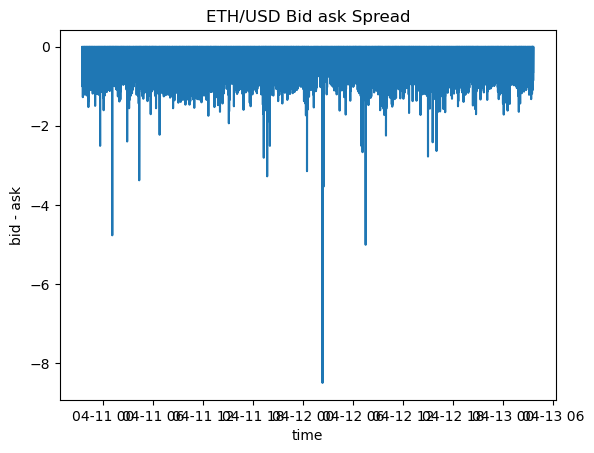

In [8]:
# Create the plot
plt.plot(ETH_USD_book_raw['timestamp_utc_nanoseconds'],ETH_USD_book_raw['Bid1PriceMillionths'] /1000000-  ETH_USD_book_raw['Ask1PriceMillionths']/1000000)

# Title and labels
plt.title('ETH/USD Bid ask Spread')
plt.xlabel('time')
plt.ylabel('bid - ask')

# Display the plot
plt.show()

#### 1.3.1.2) Graph ETH/USD Time Series

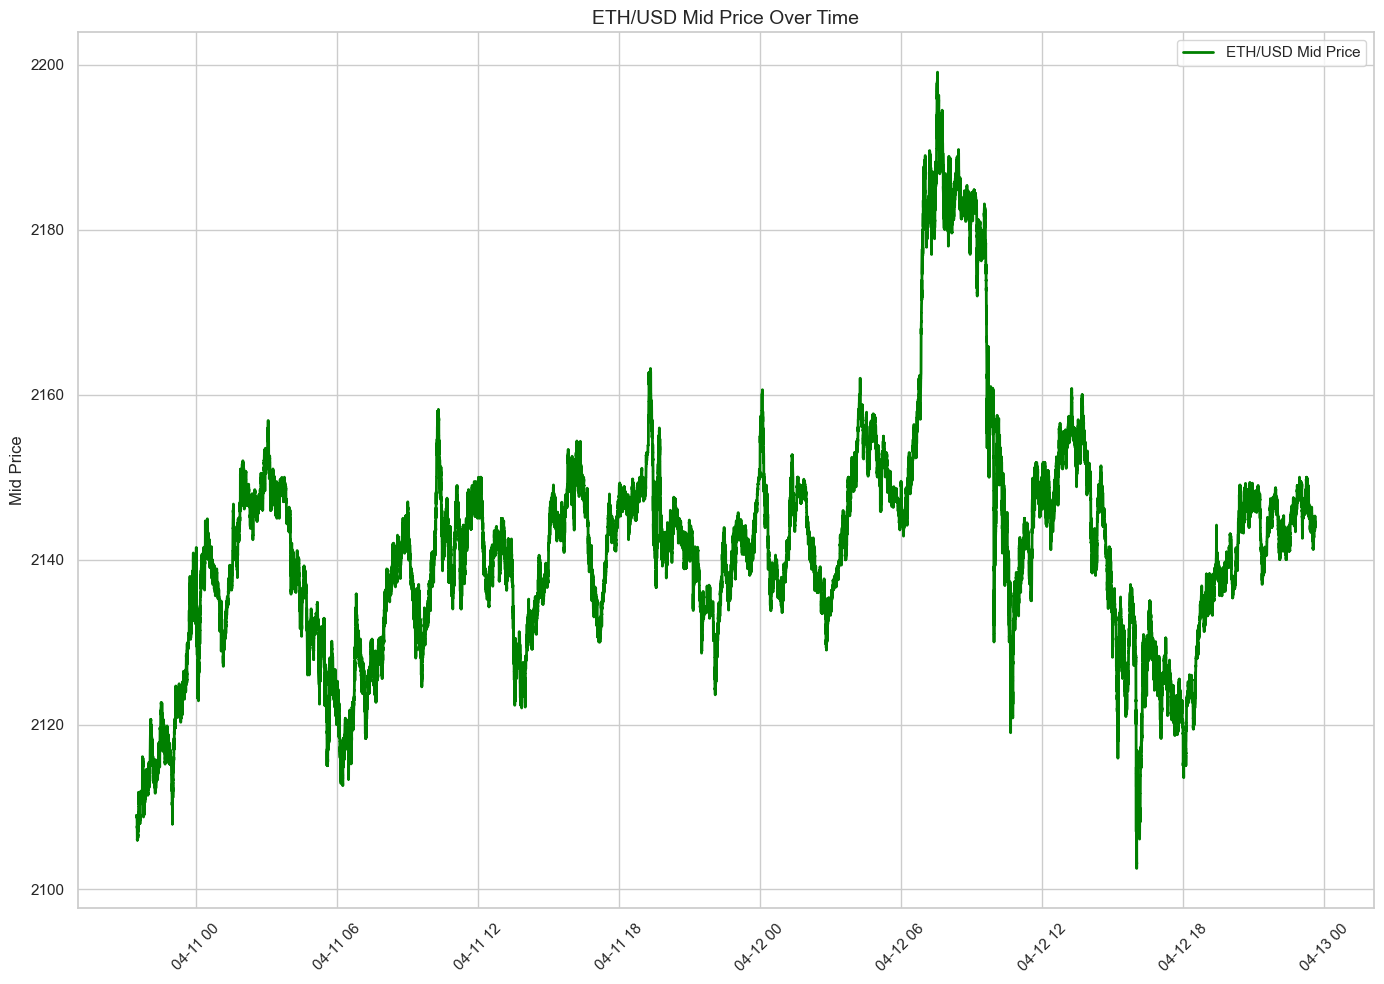

In [9]:
# Set the Seaborn theme for better aesthetics
sns.set_theme(style="whitegrid")

# Colors for the plots
colors = {
    'ETH_USD_book': 'green',
    'ETH_BTC_book': 'red',
}

# Plotting ETH/USD Mid Price
plt.figure(figsize=(14, 10))  # Create a new figure for ETH/USD
plt.plot(ETH_USD_book.index, ETH_USD_book['mid'], label='ETH/USD Mid Price', color=colors['ETH_USD_book'], linewidth=2)
plt.title('ETH/USD Mid Price Over Time', fontsize=14)
plt.ylabel('Mid Price', fontsize=12)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

we can Immediately see that this is a very volatile period for ETH, however it lacks any large trends making this a good enviroment for market making since market makers like choppy markets and high volatility because it means they can complete more buy sell pairs than they could in a trending market

### 1.3.2) ETH/USD

### 1.3.2.1) Check For Crossed Books

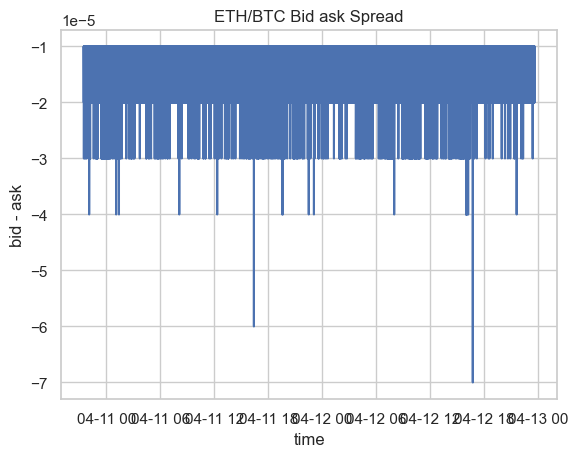

In [11]:
# Create the plot
plt.plot(ETH_BTC_book_raw['timestamp_utc_nanoseconds'],ETH_BTC_book_raw['Bid1PriceMillionths'] /1000000-  ETH_BTC_book_raw['Ask1PriceMillionths']/1000000)

# Title and labels
plt.title('ETH/BTC Bid ask Spread')
plt.xlabel('time')
plt.ylabel('bid - ask')

# Display the plot
plt.show()

### 1.3.2.2) Graph ETH/BTC Time Series

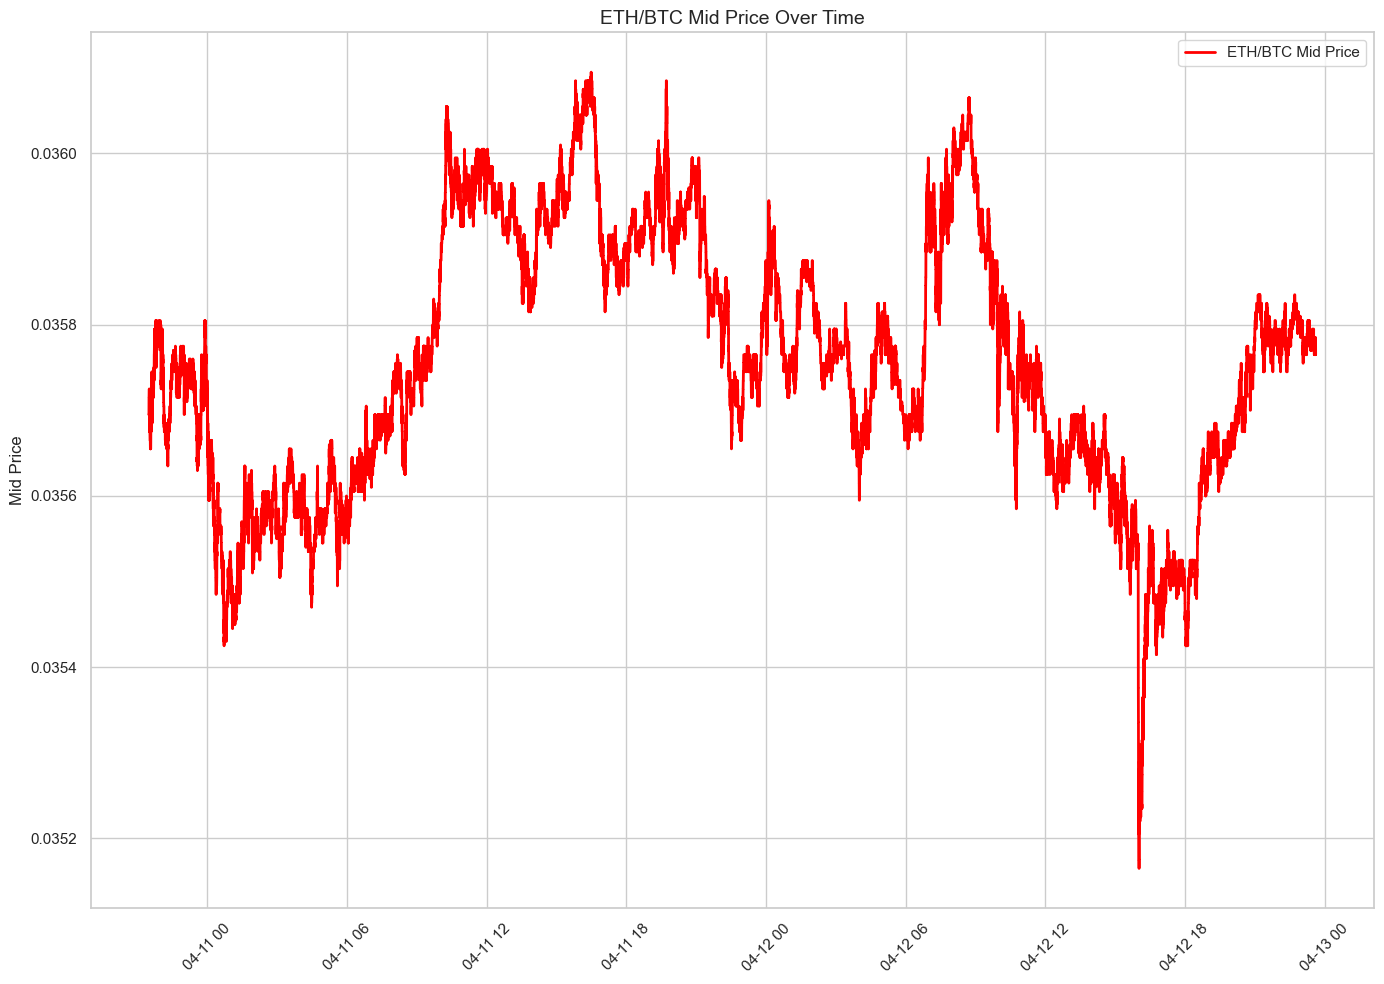

In [12]:
# Plotting ETH/BTC Mid Price
plt.figure(figsize=(14, 10))  # Create a new figure for ETH/BTC
plt.plot(ETH_BTC_book.index, ETH_BTC_book['mid'], label='ETH/BTC Mid Price', color=colors['ETH_BTC_book'], linewidth=2)
plt.title('ETH/BTC Mid Price Over Time', fontsize=14)
plt.ylabel('Mid Price', fontsize=12)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Again we can see high voaltility and we can also see it spike around the sme time as ETH indicating that they may be correlated, lets investigate this

### 1.3.3) ETH/USD vs ETH/BTC Correlation

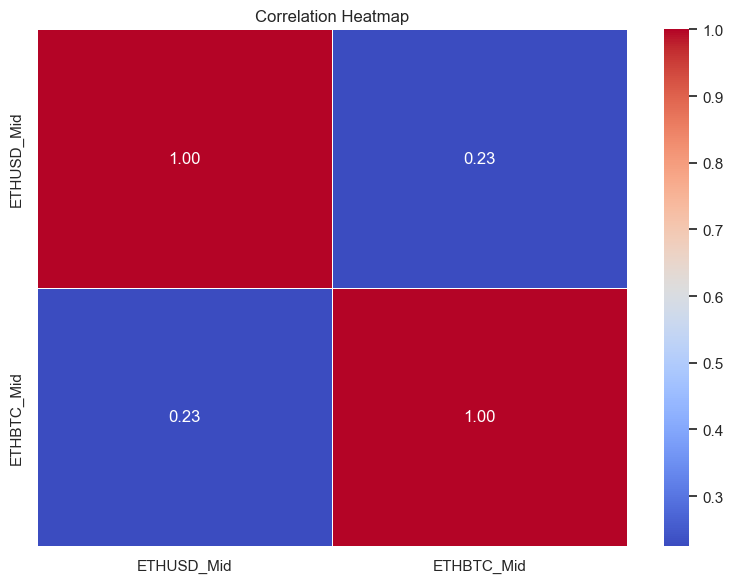

In [14]:
merged_df = pd.merge(ETH_USD_book['mid'], ETH_BTC_book['mid'], how='outer', left_index=True, right_index=True)
new_column_names = {'mid_x': "ETHUSD_Mid", 'mid_y': 'ETHBTC_Mid'}
merged_df.rename(columns=new_column_names, inplace=True)

# Calculate correlation
correlation_matrix = merged_df.corr()

# Plotting the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Correlation Heatmap')

# Adjusting aspect ratio to ensure all elements are properly displayed
plt.tight_layout()

plt.show()

We can see a non-trival Correlation between our two time series of 23%, so we will try and use cross flow and cross volume as indicators 

### 1.4) Split Into Traning and Testing Sets

For our inital run of the Strategy we will be spliting my data into traning(60%) and test sets(40%). The taining set will be used to train the regression of features vs % change in MKT_Theo and calulate a beta which I will later use to produce my signal values in the testing set.

I split before calculating any statistics so I minimize any information bleed into the test set

In [15]:
# Calculate the 60% split date for ETH_USD
split_index_eth_usd = int(len(ETH_USD_book) * 0.6)
eth_usd_split_date = ETH_USD_book.iloc[split_index_eth_usd].name

# Calculate the 60% split date for ETH_BTC
split_index_eth_btc = int(len(ETH_BTC_book) * 0.6)
eth_btc_split_date = ETH_BTC_book.iloc[split_index_eth_btc].name

# Determine the earlier date
earlier_split_date = min(eth_usd_split_date, eth_btc_split_date)

# Splitting ETH_USD data
ETH_USD_book_test, ETH_USD_book_train, ETH_USD_trades_test, ETH_USD_trades_train = \
    split_and_filter_dataframes(ETH_USD_book, ETH_USD_trades, "ETH_USD", earlier_split_date, display_data=False)

# Splitting ETH_BTC data
ETH_BTC_book_test, ETH_BTC_book_train, ETH_BTC_trades_test, ETH_BTC_trades_train = \
    split_and_filter_dataframes(ETH_BTC_book, ETH_BTC_trades, "ETH_BTC", earlier_split_date, display_data=False)

check_dataframe_integrity(ETH_USD_book_test)
check_dataframe_integrity(ETH_USD_book_train)

check_dataframe_integrity(ETH_BTC_book_test)
check_dataframe_integrity(ETH_BTC_book_train)


Check for uniqueness:                True
Check for excessively large numbers: Passed
Check for NaN values:                Passed
Check for uniqueness:                True
Check for excessively large numbers: Passed
Check for NaN values:                Passed
Check for uniqueness:                True
Check for excessively large numbers: Passed
Check for NaN values:                Passed
Check for uniqueness:                True
Check for excessively large numbers: Passed
Check for NaN values:                Passed


In [16]:
ETH_USD_size_train = construct_size_df(ETH_USD_book_train, ETH_USD_trades_train)
ETH_USD_size_cross_train = construct_size_df(ETH_USD_book_train, ETH_BTC_trades_train)
ETH_USD_size_test = construct_size_df(ETH_USD_book_test, ETH_USD_trades_test)
ETH_USD_size_cross_test = construct_size_df(ETH_USD_book_test, ETH_BTC_trades_test)

ETH_BTC_size_train = construct_size_df(ETH_BTC_book_train, ETH_BTC_trades_train)
ETH_BTC_size_cross_train = construct_size_df(ETH_BTC_book_train, ETH_USD_trades_train)
ETH_BTC_size_test = construct_size_df(ETH_BTC_book_test, ETH_BTC_trades_test)
ETH_BTC_size_cross_test = construct_size_df(ETH_BTC_book_test, ETH_USD_trades_test)


# 2) Calculate Features

To predict the percentage change in MKT_Theo, we leverage several key market features:

- **Volume**: Exponetial moving average of the amount of the asset traded within a specific time frame. Hyper parameter: Volume_halflife which inidcates the decay rate of the EWMA
- **Trade Flow**: Exponetial moving average of the net amount of asset bought or sold, indicating market direction. Hyper parameter: Volume_halflife which inidcates the decay rate of the EWMA
- **Share Imbalance**: The ratio of demand to supply in the market, derived from order book data.
- **Cross Volume**: The total amount of asset traded within a specific time frame from the correlated asset, Ethereum/Bitcoin (ETH/BTC)
- **Cross Trade Flow**: The net amount of asset bought or sold, indicating market direction from the correlated asset, Ethereum/Bitcoin (ETH/BTC)


These features, extracted from historical trading and order book data, feed into a regression model. This model is tasked with forecasting the short-term percentage change in our MKT_Theo, allowing us to adapt our market making strategy dynamically to the predicted market conditions.

## 2.1) Calulate Volume

In Pranav's personal experience trading cyrptocurrencies; volume has been a useful predictor of price change. The following is our formula for $$ \text{volume}_t$$ as an exponentially weighted moving average

$$ \text{volume}_t = (1 - e^{-\frac{\ln(2)}{\text{halflife}}}) \cdot size_t + \left(1 - \left(1 - e^{-\frac{\ln(2)}{\text{halflife}}}\right)\right) \cdot \text{volume}_{t-1} $$

In [17]:
def calc_abs_volume(df, volume_halflife = 15000):
    """
    Adds a 'volume' column to the DataFrame, calculated as the exponentially weighted moving average
    of the absolute values of the 'size' column. This implementation uses the 'halflife' parameter,
    specified in milliseconds, to define the decay rate, allowing for dynamic adjustment based on the 
    actual timing of observations. The half-life specifies the time period over which the influence of
    an observation reduces to half its original value, providing an intuitive measure for handling
    temporal decay in time series data.

    Parameters:
    - df: DataFrame containing trade data. Expected to have a datetime index and a 'size' column.
    - halflife_milliseconds: The period over which the weight of an observation in the calculation reduces
                             to half its original value, specified in milliseconds as a numeric value.

    Returns:
    - The DataFrame with an added 'volume' column, representing the dynamically adjusted exponentially 
      weighted moving average of trade sizes, using the 'halflife' parameter for decay.
    """
    # Ensure the DataFrame's index is in datetime format for time-based calculation
    df.index = pd.to_datetime(df.index)
    
    # Convert halflife from milliseconds to a pandas-compatible string format
    halflife_str = f'{volume_halflife}ms'
    
    # Apply the ewm method with the 'halflife' parameter for dynamically adjusted decay based on timing,
    # using the absolute values of the 'size' column. 'adjust=False' is used to emphasize the relevance 
    # of more recent observations without normalizing weights, and 'ignore_na=True' to handle missing values
    # by ignoring them in the calculation while still considering the timing of observations.
    df['volume'] = df['size'].abs().ewm(halflife=halflife_str, ignore_na=True, times=df.index).mean()

    df['volume'].fillna(0, inplace=True)

    return df

In [18]:
volume_halflife = 15000

ETH_USD_size_train = calc_abs_volume(ETH_USD_size_train, volume_halflife)
ETH_USD_size_cross_train = calc_abs_volume(ETH_USD_size_cross_train, volume_halflife)
ETH_USD_size_test = calc_abs_volume(ETH_USD_size_test, volume_halflife)
ETH_USD_size_cross_test = calc_abs_volume(ETH_USD_size_cross_test, volume_halflife)

ETH_BTC_size_train = calc_abs_volume(ETH_BTC_size_train, volume_halflife)
ETH_BTC_size_cross_train = calc_abs_volume(ETH_BTC_size_cross_train, volume_halflife)
ETH_BTC_size_test = calc_abs_volume(ETH_BTC_size_test, volume_halflife)
ETH_BTC_size_cross_test = calc_abs_volume(ETH_BTC_size_cross_test, volume_halflife)

display("There should be NaN's here for rows not indicating a trade which will be ignored by the Exmponetial Moving function")

"There should be NaN's here for rows not indicating a trade which will be ignored by the Exmponetial Moving function"

## 2.2) Calulate Trade_Flow

In a homework assignment from class, we considered the recent trade flow as the (sole) factor in predicting changes to mid market price. In our work here, we will be using the exponentially weighted moving average of trade flow instead of recent trade flow. This should work better as more weight will be given to more recent trades in an exponential decay model. Similar reasoning applies for why we are using exponentially weighted moving average for volume as well (instead of recent volume)

$$ \text{TradeFlow}_t = (1 - e^{-\frac{\ln(2)}{\text{halflife}}}) \cdot x_t + \left(1 - \left(1 - e^{-\frac{\ln(2)}{\text{halflife}}}\right)\right) \cdot \text{TradeFlow}_{t-1} $$


In [19]:
def Calculate_Trade_Flow(trade_data, flow_halflife = 15000):
    """
    Adds a 'flow' column to the input DataFrame, calculated as the exponentially weighted moving sum
    of the 'size' column. This version of the function adjusts for uneven time intervals between observations
    using a dynamic decay based on a half-life specified in milliseconds. The 'halflife' parameter provides an
    intuitive measure for the decay, indicating the time it takes for the influence of an observation to reduce
    to half its initial value.

    The 'times' parameter in the ewm method leverages actual timestamps, allowing for the exponential weighting
    to dynamically adjust based on the real-time passage between observations. This method is particularly useful
    for time series data that features irregular intervals between data points.

    Parameters:
    - trade_data: DataFrame containing trade data, expected to have a datetime index and a 'size' column.
    - trade_halflife: The half-life period, specified as a number of milliseconds, over which the weight
                             of an observation reduces to half its original value.

    Returns:
    - The DataFrame with an added 'flow' column, showing the dynamically adjusted exponentially weighted moving
      sum of trade sizes based on the specified 'halflife'.
    """
    # Ensure the DataFrame's index is in datetime format for time-based calculation
    trade_data.index = pd.to_datetime(trade_data.index)
    
    # Convert halflife from milliseconds to a pandas-compatible string format
    halflife_str = f'{flow_halflife}ms'
    
    # Use the datetime index as the 'times' argument and apply the 'halflife' parameter for the decay rate
    trade_data['flow'] = trade_data['size'].ewm(halflife=halflife_str, ignore_na=True, times=trade_data.index).mean()

    trade_data['flow'].fillna(0, inplace=True)

    return trade_data

In [20]:
flow_halflife = 15000 

ETH_USD_size_train = Calculate_Trade_Flow(ETH_USD_size_train, flow_halflife)
ETH_USD_size_cross_train = Calculate_Trade_Flow(ETH_USD_size_cross_train, flow_halflife)
ETH_USD_size_test = Calculate_Trade_Flow(ETH_USD_size_test, flow_halflife)
ETH_USD_size_cross_test = Calculate_Trade_Flow(ETH_USD_size_cross_test, flow_halflife)

ETH_BTC_size_train = Calculate_Trade_Flow(ETH_BTC_size_train, flow_halflife)
ETH_BTC_size_cross_train = Calculate_Trade_Flow(ETH_BTC_size_cross_train, flow_halflife)
ETH_BTC_size_test = Calculate_Trade_Flow(ETH_BTC_size_test, flow_halflife)
ETH_BTC_size_cross_test = Calculate_Trade_Flow(ETH_BTC_size_cross_test, flow_halflife)

display(ETH_USD_size_train)
display(ETH_USD_size_cross_train)

,size,volume,flow
time,,,
2021-04-10 21:28:54.547039,0.499500,0.499500,0.499500
2021-04-10 21:28:54.563411,NaN,0.499500,0.499500
2021-04-10 21:28:54.797956,0.036209,0.266599,0.266599
2021-04-10 21:28:55.123831,0.499500,0.345295,0.345295
2021-04-10 21:28:55.368753,NaN,0.345295,0.345295
...,...,...,...
2021-04-12 02:45:38.515705,NaN,0.531431,-0.113702
2021-04-12 02:45:38.825391,-0.771850,0.532580,-0.116848
2021-04-12 02:45:38.919978,NaN,0.532580,-0.116848


,size,volume,flow
time,,,
2021-04-10 21:28:54.547039,NaN,0.000000,0.000000
2021-04-10 21:28:54.563411,NaN,0.000000,0.000000
2021-04-10 21:28:54.797956,NaN,0.000000,0.000000
2021-04-10 21:28:55.123831,NaN,0.000000,0.000000
2021-04-10 21:28:55.368753,NaN,0.000000,0.000000
...,...,...,...
2021-04-12 02:45:38.515705,NaN,0.662229,0.081778
2021-04-12 02:45:38.825391,NaN,0.662229,0.081778
2021-04-12 02:45:38.919978,NaN,0.662229,0.081778


### Add indicators to Order Book data frame

In [21]:
# Update training and testing datasets for ETH_USD with direct volume and flow information
ETH_USD_book_train = add_volume_and_flow_to_book(ETH_USD_book_train, ETH_USD_size_train)
ETH_USD_book_train = add_cross_volume_and_flow_to_book(ETH_USD_book_train, ETH_USD_size_cross_train)
ETH_USD_book_test = add_volume_and_flow_to_book(ETH_USD_book_test, ETH_USD_size_test)
ETH_USD_book_test = add_cross_volume_and_flow_to_book(ETH_USD_book_test, ETH_USD_size_cross_test)


# Update training and testing datasets for ETH_BTC with direct volume and flow information
ETH_BTC_book_train = add_volume_and_flow_to_book(ETH_BTC_book_train, ETH_BTC_size_train)
ETH_BTC_book_train = add_cross_volume_and_flow_to_book(ETH_BTC_book_train, ETH_BTC_size_cross_train)
ETH_BTC_book_test = add_volume_and_flow_to_book(ETH_BTC_book_test, ETH_BTC_size_test)
ETH_BTC_book_test = add_cross_volume_and_flow_to_book(ETH_BTC_book_test, ETH_BTC_size_cross_test)


check_dataframe_integrity(ETH_USD_book_train)
check_dataframe_integrity(ETH_USD_book_test)

check_dataframe_integrity(ETH_BTC_book_train)
check_dataframe_integrity(ETH_BTC_book_test)

Check for uniqueness:                True
Check for excessively large numbers: Passed
Check for NaN values:                Passed
Check for uniqueness:                True
Check for excessively large numbers: Passed
Check for NaN values:                Passed
Check for uniqueness:                True
Check for excessively large numbers: Passed
Check for NaN values:                Passed
Check for uniqueness:                True
Check for excessively large numbers: Passed
Check for NaN values:                Passed


## 2.3) Calulate Current Share Imbalance 

$$\frac{size\_best\_bid}{size\_best\_bid + size\_best\_ask}$$


Share imbalance is a factor used in https://www.mdpi.com/2673-4591/38/1/74icting to predict changes in mid market price in "Mid-Price Prediction in a Limit Order Book" by Deepan Palguna and Ilya Pollak. The idea behind this is that if there are alot more bids in the current book than there are offers it may be a signal that there is alot of demand for the product and the price may rise and vice versa.


In [22]:
def calculate_share_imbalance(df):
    """
    Adds a 'share_imbalance' column to the DataFrame based on the formula:
    bid_size_1 / (bid_size_1 + ask_size_1)
    
    Parameters:
    - df: pandas DataFrame with columns 'bid_size_1' and 'ask_size_1'
    
    Returns:
    - DataFrame with an additional 'share_imbalance' column
    """
    # Calculate the share imbalance
    df['share_imbalance'] = df['bid_size_1'] / (df['bid_size_1'] + df['ask_size_1'])
    
    return df

# Apply the calculate_share_imbalance function to each data frame

ETH_USD_book_test = calculate_share_imbalance(ETH_USD_book_test)
ETH_USD_book_train = calculate_share_imbalance(ETH_USD_book_train)

ETH_BTC_book_test = calculate_share_imbalance(ETH_BTC_book_test)
ETH_BTC_book_train = calculate_share_imbalance(ETH_BTC_book_train)

display(ETH_USD_book_train)

,ask_price_1,bid_price_1,ask_size_1,bid_size_1,ask_price_2,bid_price_2,ask_size_2,bid_size_2,mid,volume,flow,cross_volume,cross_flow,share_imbalance
time,,,,,,,,,,,,,,
2021-04-10 21:28:54.547039,2109.00,2108.99,14.095270,9.377656,2109.03,2108.98,6.453440,3.0000,2108.995,0.499500,0.499500,0.000000,0.000000,0.399509
2021-04-10 21:28:54.563411,2109.00,2108.99,14.095270,9.377656,2109.03,2108.97,6.453440,2.0107,2108.995,0.499500,0.499500,0.000000,0.000000,0.399509
2021-04-10 21:28:54.797956,2109.00,2108.99,14.059061,9.377656,2109.03,2108.97,6.453440,2.0107,2108.995,0.266599,0.266599,0.000000,0.000000,0.400127
2021-04-10 21:28:55.123831,2109.00,2108.99,13.559561,9.377656,2109.03,2108.97,6.453440,2.0107,2108.995,0.345295,0.345295,0.000000,0.000000,0.408840
2021-04-10 21:28:55.368753,2109.00,2108.99,13.559561,9.277578,2109.03,2108.97,6.453440,2.0107,2108.995,0.345295,0.345295,0.000000,0.000000,0.406250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-12 02:45:38.515705,2134.01,2134.00,98.358840,13.469596,2134.04,2133.53,3.999587,4.1000,2134.005,0.531431,-0.113702,0.662229,0.081778,0.120449
2021-04-12 02:45:38.825391,2134.01,2134.00,98.358840,12.697746,2134.04,2133.53,3.999587,4.1000,2134.005,0.532580,-0.116848,0.662229,0.081778,0.114336
2021-04-12 02:45:38.919978,2134.01,2134.00,98.358840,12.697746,2134.04,2133.53,3.999587,4.1000,2134.005,0.532580,-0.116848,0.662229,0.081778,0.114336


## 2.4) Autocorrelation 

According to this paper, https://journals.plos.org/plosone/article/file?id=10.1371/journal.pone.0234107&type=printable, autocorrelation was a very powerful feature impacting mid market price predictions, so we will be using it in our regression. Using the professors advice we decide to only use 1 lag

### 2.4.1) Calulate Market Theo

$$ \sum_{i}{B_{i_s} \cdot \exp(B_{i_p} - x)/tick)} + \sum_{j}{A_{j_s} \cdot \exp((x - S_{j_p})/tick)} $$

The MKT_Theo is the value of $x$ that minimizes the above formula, where $B_i$ are the bids with $B_{i_p}$ being the price of the bid, and $B_{i_s}$ being the size of the bid, and similarly for the $A_j$ for the asks. Unlike mid-market price; mkt_theo takes into account all orders in the orderbook; takes into the account the relative sizes of the bids vs the asks, and may cross the est bid or best ask in certain circumstances. This makes it a better first-order value to trade around the mid-market price; and we will try to forecast changes in mkt_theo as our next general step. 

In [ ]:

def minimize_x(bid1_p, bid1_s, bid2_p, bid2_s, ask1_p, ask1_s, ask2_p, ask2_s, mid,tick):
    def func(x):
        return  (bid1_s * math.exp((bid1_p - x)/tick) +
                bid2_s * math.exp((bid2_p - x)/tick) +
                ask1_s * math.exp((x - ask1_p)/tick) +
                ask2_s * math.exp((x - ask2_p)/tick))
    def deriv(x):
        return ((ask1_s * math.exp((x - ask1_p)/tick) +
                ask2_s * math.exp((x - ask2_p)/tick) -
                bid1_s * math.exp((bid1_p - x)/tick) -
                bid2_s * math.exp((bid2_p - x)/tick))/tick)
    res = sp.optimize.minimize(func, [mid,], jac=deriv, method='L-BFGS-B', tol=tick/2.0, options={'gtol': tick/2.0, 'eps': tick/2.0})

    return float(res.x[0])  # Explicitly convert the result to float

In [ ]:

ETH_USD_book_test['MKT_Theo'] = ETH_USD_book_test.apply(
    lambda y: minimize_x(y["bid_price_1"], y["bid_size_1"],
                         y["bid_price_2"], y["bid_size_2"],
                         y["ask_price_1"], y["ask_size_1"],
                         y["ask_price_2"], y["ask_size_2"],
                         y["mid"],0.01), axis=1)


C:\Users\jackm\AppData\Local\Temp\ipykernel_37288\3646602428.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
C:\Users\jackm\AppData\Local\Temp\ipykernel_37288\3646602428.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
C:\Users\jackm\AppData\Local\Temp\ipykernel_37288\3646602428.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
C:\Users\jackm\AppData\Local\Temp\ipykernel_37288\3646602428.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar 

In [ ]:

ETH_USD_book_train['MKT_Theo'] = ETH_USD_book_train.apply(
    lambda y: minimize_x(y["bid_price_1"], y["bid_size_1"],
                         y["bid_price_2"], y["bid_size_2"],
                         y["ask_price_1"], y["ask_size_1"],
                         y["ask_price_2"], y["ask_size_2"],
                         y["mid"],0.01), axis=1)


C:\Users\jackm\AppData\Local\Temp\ipykernel_37288\3646602428.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
C:\Users\jackm\AppData\Local\Temp\ipykernel_37288\3646602428.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
C:\Users\jackm\AppData\Local\Temp\ipykernel_37288\3646602428.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
C:\Users\jackm\AppData\Local\Temp\ipykernel_37288\3646602428.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar 

## DO NOT RE-RUN

In [23]:
ETH_USD_book_train_mkt = pd.read_csv("ETH_USD_book_train.csv")
ETH_USD_book_test_mkt = pd.read_csv("ETH_USD_book_test.csv")
ETH_BTC_book_train_mkt = pd.read_csv("ETH_BTC_book_train.csv")
ETH_BTC_book_test_mkt = pd.read_csv("ETH_BTC_book_test.csv")

In [24]:
ETH_USD_book_train_mkt_ind = ETH_USD_book_train_mkt.set_index(pd.to_datetime(ETH_USD_book_train_mkt['time']))
ETH_USD_book_test_mkt_ind = ETH_USD_book_test_mkt.set_index(pd.to_datetime(ETH_USD_book_test_mkt['time']))
ETH_BTC_book_train_mkt_ind = ETH_BTC_book_train_mkt.set_index(pd.to_datetime(ETH_BTC_book_train_mkt['time']))
ETH_BTC_book_test_mkt_ind = ETH_BTC_book_test_mkt.set_index(pd.to_datetime(ETH_BTC_book_test_mkt['time']))

In [25]:
ETH_USD_book_train['MKT_Theo'] = ETH_USD_book_train_mkt_ind['MKT_Theo']
ETH_USD_book_test['MKT_Theo'] = ETH_USD_book_test_mkt_ind['MKT_Theo']
ETH_BTC_book_train['MKT_Theo'] = ETH_BTC_book_train_mkt_ind['MKT_Theo']
ETH_BTC_book_test['MKT_Theo'] = ETH_BTC_book_test_mkt_ind['MKT_Theo']

In [26]:

# save local copy of market theo
ETH_USD_book_test_cpy= ETH_USD_book_test.copy(deep= True)
ETH_USD_book_train_cpy = ETH_USD_book_train.copy(deep= True)
ETH_BTC_book_test_cpy = ETH_BTC_book_test.copy(deep= True)
ETH_BTC_book_train_cpy = ETH_BTC_book_train.copy(deep= True)

ETH_USD_trades_test_cpy= ETH_USD_trades_test.copy(deep= True)
ETH_USD_trades_train_cpy = ETH_USD_trades_train.copy(deep= True)
ETH_BTC_trades_test_cpy = ETH_BTC_trades_test.copy(deep= True)
ETH_BTC_trades_train_cpy = ETH_BTC_trades_train.copy(deep= True)


In [27]:
# save local copy of market theo
ETH_USD_book_test_MKT_Theo = ETH_USD_book_test['MKT_Theo'].copy()
ETH_USD_book_train_MKT_Theo = ETH_USD_book_train['MKT_Theo'].copy()
ETH_BTC_book_test_MKT_Theo = ETH_BTC_book_test['MKT_Theo'].copy()
ETH_BTC_book_train_MKT_Theo = ETH_BTC_book_train['MKT_Theo'].copy()

# CHECKPOINT

In [ ]:
ETH_USD_book_test['MKT_Theo']=ETH_USD_book_test_MKT_Theo
ETH_USD_book_train['MKT_Theo']=ETH_USD_book_train_MKT_Theo
ETH_BTC_book_test['MKT_Theo']=ETH_BTC_book_test_MKT_Theo
ETH_BTC_book_train['MKT_Theo']=ETH_BTC_book_train_MKT_Theo

In [60]:
ETH_USD_book_test = ETH_USD_book_test_cpy.copy(deep=True)
ETH_USD_book_train = ETH_USD_book_train_cpy.copy(deep=True)
ETH_BTC_book_test = ETH_BTC_book_test_cpy.copy(deep=True)
ETH_BTC_book_train = ETH_BTC_book_train_cpy.copy(deep=True)
display(ETH_USD_book_train)
display(ETH_BTC_book_train)
display(ETH_BTC_book_test_MKT_Theo)

,ask_price_1,bid_price_1,ask_size_1,bid_size_1,ask_price_2,bid_price_2,ask_size_2,bid_size_2,mid,volume,flow,cross_volume,cross_flow,share_imbalance,MKT_Theo
time,,,,,,,,,,,,,,,
2021-04-10 21:28:54.547039,2109.00,2108.99,14.095270,9.377656,2109.03,2108.98,6.453440,3.0000,2108.995,0.499500,0.499500,0.000000,0.000000,0.399509,2108.993406
2021-04-10 21:28:54.563411,2109.00,2108.99,14.095270,9.377656,2109.03,2108.97,6.453440,2.0107,2108.995,0.499500,0.499500,0.000000,0.000000,0.399509,2108.992993
2021-04-10 21:28:54.797956,2109.00,2108.99,14.059061,9.377656,2109.03,2108.97,6.453440,2.0107,2108.995,0.266599,0.266599,0.000000,0.000000,0.400127,2108.993005
2021-04-10 21:28:55.123831,2109.00,2108.99,13.559561,9.377656,2109.03,2108.97,6.453440,2.0107,2108.995,0.345295,0.345295,0.000000,0.000000,0.408840,2108.993182
2021-04-10 21:28:55.368753,2109.00,2108.99,13.559561,9.277578,2109.03,2108.97,6.453440,2.0107,2108.995,0.345295,0.345295,0.000000,0.000000,0.406250,2108.993130
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-12 02:45:38.515705,2134.01,2134.00,98.358840,13.469596,2134.04,2133.53,3.999587,4.1000,2134.005,0.531431,-0.113702,0.662229,0.081778,0.120449,2133.994973
2021-04-12 02:45:38.825391,2134.01,2134.00,98.358840,12.697746,2134.04,2133.53,3.999587,4.1000,2134.005,0.532580,-0.116848,0.662229,0.081778,0.114336,2133.994677
2021-04-12 02:45:38.919978,2134.01,2134.00,98.358840,12.697746,2134.04,2133.53,3.999587,4.1000,2134.005,0.532580,-0.116848,0.662229,0.081778,0.114336,2133.994677


,ask_price_1,bid_price_1,ask_size_1,bid_size_1,ask_price_2,bid_price_2,ask_size_2,bid_size_2,mid,volume,flow,cross_volume,cross_flow,share_imbalance,MKT_Theo
time,,,,,,,,,,,,,,,
2021-04-10 21:28:55.799659,0.03570,0.03569,11.872084,32.957204,0.03571,0.03568,31.032423,45.284575,0.035695,0.00000,0.000000,0.384981,0.384981,0.735171,0.035699
2021-04-10 21:28:56.388074,0.03570,0.03569,11.872084,32.957204,0.03571,0.03568,30.332423,45.284575,0.035695,0.00000,0.000000,0.408861,0.408861,0.735171,0.035699
2021-04-10 21:28:57.078119,0.03570,0.03569,11.872084,32.957204,0.03571,0.03568,22.332423,45.284575,0.035695,0.00000,0.000000,0.468410,0.162043,0.735171,0.035700
2021-04-10 21:28:57.082698,0.03570,0.03569,11.872084,32.957204,0.03571,0.03568,22.332423,45.284575,0.035695,0.00000,0.000000,0.468410,0.162043,0.735171,0.035700
2021-04-10 21:28:57.157544,0.03570,0.03569,11.872084,32.956204,0.03571,0.03568,22.332423,45.284575,0.035695,0.00100,-0.001000,0.468410,0.162043,0.735165,0.035700
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-12 02:45:38.725596,0.03576,0.03575,11.720453,0.811590,0.03577,0.03574,32.634577,14.004332,0.035755,0.52434,0.064817,0.498279,-0.084424,0.064761,0.035748
2021-04-12 02:45:38.790558,0.03576,0.03575,11.720453,1.029673,0.03577,0.03574,32.634577,14.004332,0.035755,0.52434,0.064817,0.498279,-0.084424,0.080758,0.035748
2021-04-12 02:45:38.829014,0.03576,0.03575,11.720453,0.811590,0.03577,0.03574,32.634577,14.004332,0.035755,0.52434,0.064817,0.499629,-0.087816,0.064761,0.035748


time
2021-04-12 02:45:38.998099    0.035748
2021-04-12 02:45:39.208136    0.035749
2021-04-12 02:45:39.216913    0.035747
2021-04-12 02:45:39.329164    0.035747
2021-04-12 02:45:39.332779    0.035747
                                ...   
2021-04-12 23:36:57.292351    0.035767
2021-04-12 23:36:57.792847    0.035770
2021-04-12 23:36:57.822640    0.035771
2021-04-12 23:36:57.836039    0.035771
2021-04-12 23:36:57.846283    0.035771
Name: MKT_Theo, Length: 1131748, dtype: float64

### 2.4.2) Reindex data to a sensible uniform length of which we will predict over

In order to calulate ACF/ PACF our data needs to be in uniform intervals, these intervals will turn into the length of time for which we are predicting over. It would make sense to create prdictions over the average time between recieving new (unique) order book data which are shown above. Thus on average we are predicting what the mid price of the next Limit order book will be. 

In [28]:
calculate_time_deltas(ETH_USD_book_raw, ETH_USD_trades_raw, "ETH_USD")


ETH_USD:
Book: Average time delta: 0 days 00:00:00.016521114
Book: Median time delta: 0 days 00:00:00.004566
Trades: Average time delta: 0 days 00:00:00.635564984
Trades: Median time delta: 0 days 00:00:00.342038


Book: Average time delta between unique instances: 0 days 00:00:00.016521114
Book: Median time delta between unique instances: 0 days 00:00:00.004566
Trades: Average time delta between unique instances: 0 days 00:00:00.747911222
Trades: Median time delta between unique instances: 0 days 00:00:00.463102


It looks like we should start with 5 ms as our prediction interval as that the median time between recieving unique trades

In [29]:
ETH_USD_book_train_reindexed = reindex_dataframe_to_uniform_intervals(ETH_USD_book_train, 5)

display(ETH_USD_book_train_reindexed)

,ask_price_1,bid_price_1,ask_size_1,bid_size_1,ask_price_2,bid_price_2,ask_size_2,bid_size_2,mid,volume,flow,cross_volume,cross_flow,share_imbalance,MKT_Theo
2021-04-10 21:28:54.547039,2109.00,2108.99,14.09527,9.377656,2109.03,2108.98,6.453440,3.0000,2108.995,0.49950,0.499500,0.000000,0.000000,0.399509,2108.993406
2021-04-10 21:28:54.552039,2109.00,2108.99,14.09527,9.377656,2109.03,2108.98,6.453440,3.0000,2108.995,0.49950,0.499500,0.000000,0.000000,0.399509,2108.993406
2021-04-10 21:28:54.557039,2109.00,2108.99,14.09527,9.377656,2109.03,2108.98,6.453440,3.0000,2108.995,0.49950,0.499500,0.000000,0.000000,0.399509,2108.993406
2021-04-10 21:28:54.562039,2109.00,2108.99,14.09527,9.377656,2109.03,2108.98,6.453440,3.0000,2108.995,0.49950,0.499500,0.000000,0.000000,0.399509,2108.993406
2021-04-10 21:28:54.567039,2109.00,2108.99,14.09527,9.377656,2109.03,2108.97,6.453440,2.0107,2108.995,0.49950,0.499500,0.000000,0.000000,0.399509,2108.992993
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-12 02:45:38.922039,2134.01,2134.00,98.35884,12.697746,2134.04,2133.53,3.999587,4.1000,2134.005,0.53258,-0.116848,0.662229,0.081778,0.114336,2133.994677
2021-04-12 02:45:38.927039,2134.01,2134.00,98.35884,12.697746,2134.04,2133.53,3.999587,4.1000,2134.005,0.53258,-0.116848,0.662229,0.081778,0.114336,2133.994677
2021-04-12 02:45:38.932039,2134.01,2134.00,98.35884,12.697746,2134.04,2133.53,3.999587,4.1000,2134.005,0.53258,-0.116848,0.662229,0.081778,0.114336,2133.994677
2021-04-12 02:45:38.937039,2134.01,2134.00,98.35884,12.697746,2134.04,2133.53,3.999587,4.1000,2134.005,0.53258,-0.116848,0.662229,0.081778,0.114336,2133.994677


### 2.4.3 Calculate % Change in Market Theo

In [30]:
column_name = 'MKT_Theo'

ETH_USD_book_test = percent_change(ETH_USD_book_test, column_name)
ETH_USD_book_train_reindexed = percent_change(ETH_USD_book_train_reindexed, column_name)

display(ETH_USD_book_train_reindexed)

,ask_price_1,bid_price_1,ask_size_1,bid_size_1,ask_price_2,bid_price_2,ask_size_2,bid_size_2,mid,volume,flow,cross_volume,cross_flow,share_imbalance,MKT_Theo,MKT_Theo_%
2021-04-10 21:28:54.547039,2109.00,2108.99,14.09527,9.377656,2109.03,2108.98,6.453440,3.0000,2108.995,0.49950,0.499500,0.000000,0.000000,0.399509,2108.993406,0.000000e+00
2021-04-10 21:28:54.552039,2109.00,2108.99,14.09527,9.377656,2109.03,2108.98,6.453440,3.0000,2108.995,0.49950,0.499500,0.000000,0.000000,0.399509,2108.993406,0.000000e+00
2021-04-10 21:28:54.557039,2109.00,2108.99,14.09527,9.377656,2109.03,2108.98,6.453440,3.0000,2108.995,0.49950,0.499500,0.000000,0.000000,0.399509,2108.993406,0.000000e+00
2021-04-10 21:28:54.562039,2109.00,2108.99,14.09527,9.377656,2109.03,2108.98,6.453440,3.0000,2108.995,0.49950,0.499500,0.000000,0.000000,0.399509,2108.993406,0.000000e+00
2021-04-10 21:28:54.567039,2109.00,2108.99,14.09527,9.377656,2109.03,2108.97,6.453440,2.0107,2108.995,0.49950,0.499500,0.000000,0.000000,0.399509,2108.992993,-1.959642e-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-12 02:45:38.922039,2134.01,2134.00,98.35884,12.697746,2134.04,2133.53,3.999587,4.1000,2134.005,0.53258,-0.116848,0.662229,0.081778,0.114336,2133.994677,0.000000e+00
2021-04-12 02:45:38.927039,2134.01,2134.00,98.35884,12.697746,2134.04,2133.53,3.999587,4.1000,2134.005,0.53258,-0.116848,0.662229,0.081778,0.114336,2133.994677,0.000000e+00
2021-04-12 02:45:38.932039,2134.01,2134.00,98.35884,12.697746,2134.04,2133.53,3.999587,4.1000,2134.005,0.53258,-0.116848,0.662229,0.081778,0.114336,2133.994677,0.000000e+00
2021-04-12 02:45:38.937039,2134.01,2134.00,98.35884,12.697746,2134.04,2133.53,3.999587,4.1000,2134.005,0.53258,-0.116848,0.662229,0.081778,0.114336,2133.994677,0.000000e+00


### 2.4.4) adding lags 

In [32]:
# Example usage:
# Specify the column name and the number of lags
column_name = 'MKT_Theo_%'
num_lags = 0  # For instance, to include 2 lags

# Apply the function to each DataFrame
ETH_USD_book_test = add_lags_and_dep_var(ETH_USD_book_test, column_name, num_lags)
ETH_USD_book_train_reindexed = add_lags_and_dep_var(ETH_USD_book_train_reindexed, column_name, num_lags)

columns_to_keep = ["volume", "flow", "share_imbalance", "y","MKT_Theo_%",'cross_volume','cross_flow']#,"mid-1","mid-2"]

# Filter each data frame to keep only the specified columns
ETH_USD_book_test = ETH_USD_book_test[columns_to_keep]
ETH_USD_book_train_reindexed = ETH_USD_book_train_reindexed[columns_to_keep]

display(ETH_USD_book_test)
display(ETH_USD_book_train_reindexed)

,volume,flow,share_imbalance,y,MKT_Theo_%,cross_volume,cross_flow
time,,,,,,,
2021-04-12 02:45:38.957128,0.000000,0.000000,0.115253,1.916935e-09,0.000000e+00,0.000000,0.000000
2021-04-12 02:45:38.961381,0.000000,0.000000,0.115253,0.000000e+00,1.916935e-09,0.000000,0.000000
2021-04-12 02:45:39.146444,0.000000,0.000000,0.115253,0.000000e+00,0.000000e+00,0.000000,0.000000
2021-04-12 02:45:39.272787,0.000000,0.000000,0.115253,0.000000e+00,0.000000e+00,0.000000,0.000000
2021-04-12 02:45:39.278558,0.000000,0.000000,0.115253,-1.916935e-09,0.000000e+00,0.000000,0.000000
...,...,...,...,...,...,...,...
2021-04-12 23:36:57.833449,0.540698,0.039867,0.963531,0.000000e+00,-1.140322e-06,0.697484,0.184839
2021-04-12 23:36:57.839855,0.540698,0.039867,0.963531,0.000000e+00,0.000000e+00,0.697484,0.184839
2021-04-12 23:36:57.839933,0.540698,0.039867,0.963531,0.000000e+00,0.000000e+00,0.697484,0.184839


,volume,flow,share_imbalance,y,MKT_Theo_%,cross_volume,cross_flow
2021-04-10 21:28:54.547039,0.49950,0.499500,0.399509,0.000000e+00,0.000000e+00,0.000000,0.000000
2021-04-10 21:28:54.552039,0.49950,0.499500,0.399509,0.000000e+00,0.000000e+00,0.000000,0.000000
2021-04-10 21:28:54.557039,0.49950,0.499500,0.399509,0.000000e+00,0.000000e+00,0.000000,0.000000
2021-04-10 21:28:54.562039,0.49950,0.499500,0.399509,-1.959642e-07,0.000000e+00,0.000000,0.000000
2021-04-10 21:28:54.567039,0.49950,0.499500,0.399509,0.000000e+00,-1.959642e-07,0.000000,0.000000
...,...,...,...,...,...,...,...
2021-04-12 02:45:38.922039,0.53258,-0.116848,0.114336,0.000000e+00,0.000000e+00,0.662229,0.081778
2021-04-12 02:45:38.927039,0.53258,-0.116848,0.114336,0.000000e+00,0.000000e+00,0.662229,0.081778
2021-04-12 02:45:38.932039,0.53258,-0.116848,0.114336,0.000000e+00,0.000000e+00,0.662229,0.081778
2021-04-12 02:45:38.937039,0.53258,-0.116848,0.114336,0.000000e+00,0.000000e+00,0.662229,0.081778


# 3) Examinaiton of Featues

### 3.1) MKT_Theo_% vs volume

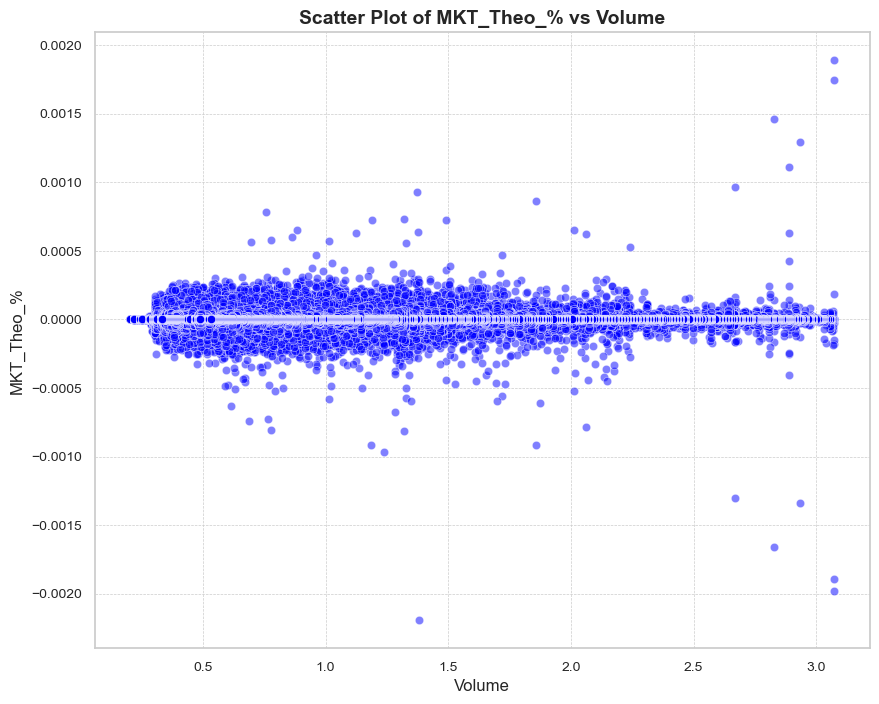

In [33]:
# Assuming 'ETH_USD_book_train_reindexed' is your DataFrame
create_enhanced_scatterplot(df=ETH_USD_book_train_reindexed,
                            x_col='volume',
                            y_col='MKT_Theo_%',
                            title='Scatter Plot of MKT_Theo_% vs Volume',
                            xlabel='Volume',
                            ylabel='MKT_Theo_%')

There seems to be very little correlation between MKT_Theo_% change and volume for the majority of the data. However, if you look at the outliers with very high volume; it seems here that MKT_Theo_% change is positive more often than not. This lines up with a somewhat successful trading strategy I use on BTCUSD where I purchase when the volume is many times higher than the average volume. 

### 3.2) MKT_Theo_% vs Trade_flow

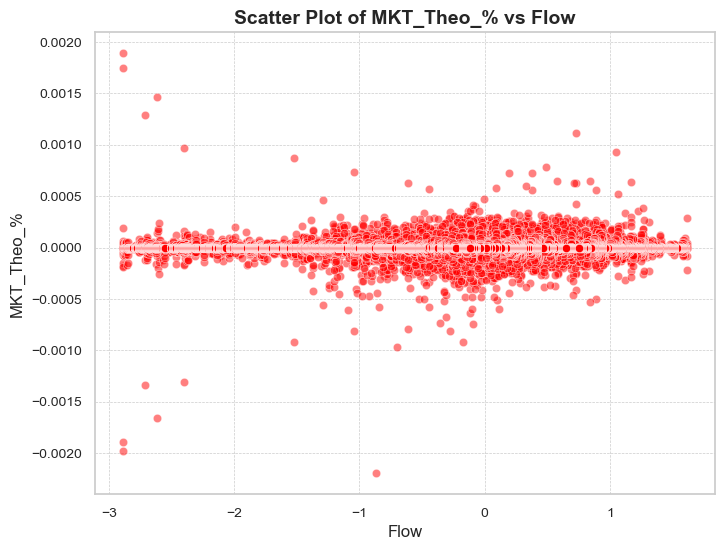

In [34]:
create_enhanced_scatterplot(df=ETH_USD_book_train_reindexed,
                            x_col='flow',
                            y_col='MKT_Theo_%',
                            title='Scatter Plot of MKT_Theo_% vs Flow',
                            xlabel='Flow',
                            ylabel='MKT_Theo_%',
                            figsize=(8, 6),
                            style='seaborn-darkgrid', # This uses the default style set in the function
                            point_color='red', # Default color set in the function
                            alpha=0.5, # Default transparency set in the function
                            edgecolor='w', # Default edge color set in the function
                            linewidth=0.5) # Default line width set in the function


### 3.3) MKT_Theo_% vs Share Imbalance

the market appears to be more volatile when flow is very negative. Additionally, it seems to be that MKT_Theo_% is positive more often than not when flow is positive, or at least there are more positive outliers. 

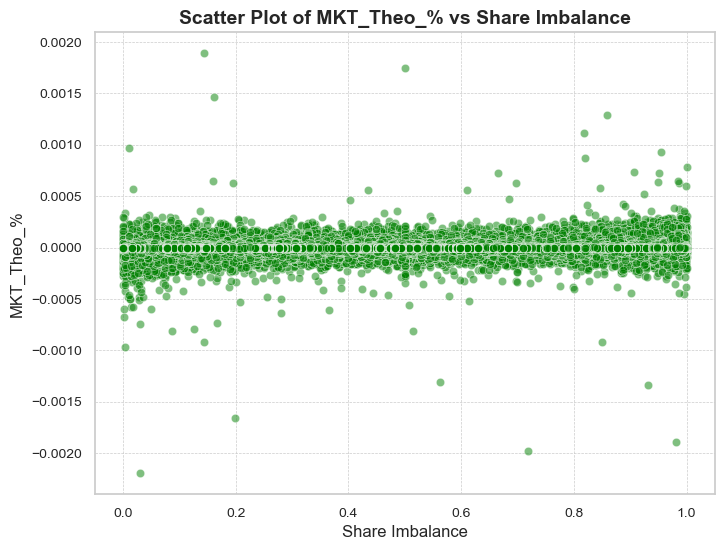

In [35]:
create_enhanced_scatterplot(df=ETH_USD_book_train_reindexed,
                            x_col='share_imbalance',
                            y_col='MKT_Theo_%',
                            title='Scatter Plot of MKT_Theo_% vs Share Imbalance',
                            xlabel='Share Imbalance',
                            ylabel='MKT_Theo_%',
                            figsize=(8, 6),
                            point_color='green', # Default color set in the function
)


There do not seem to be any noticeable trends in this graph. This may be because mkt_theo already takes into account the different sizes between bids and asks, so share imbalance will not meaningfully predict a change in mkt_theo. 

### 3.4) MKT_Theo_% vs Cross Volume

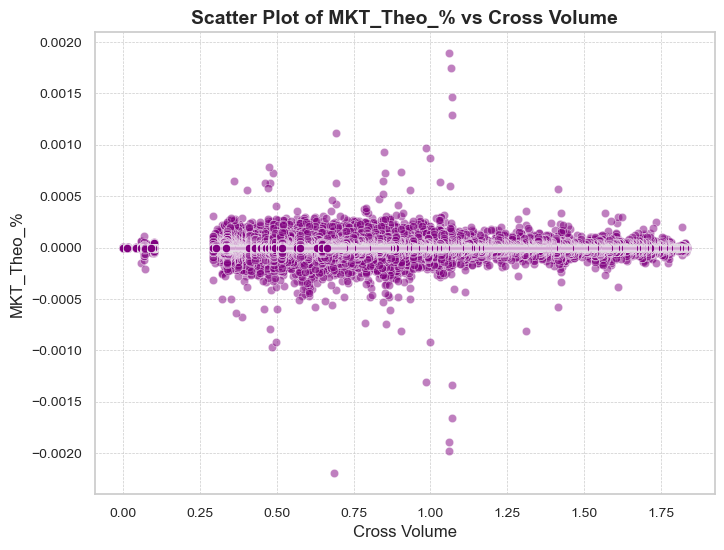

In [36]:
create_enhanced_scatterplot(df=ETH_USD_book_train_reindexed,
                            x_col='cross_volume',
                            y_col='MKT_Theo_%',
                            title='Scatter Plot of MKT_Theo_% vs Cross Volume',
                            xlabel='Cross Volume',
                            ylabel='MKT_Theo_%',
                            figsize=(8, 6),
                            point_color='purple')


There doesn't seem to be any noticeable correlation. It seems for some reason that when volume is approximately 1, there seems to be much more variance in ETH_USD. I am struggling to think of an economic reason for this. 

### 3.5) MKT_Theo_% vs Cross-Flow

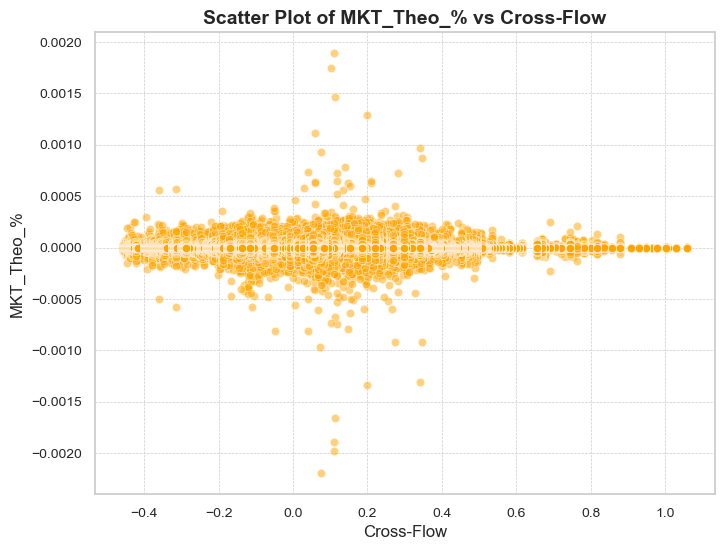

In [37]:
create_enhanced_scatterplot(df=ETH_USD_book_train_reindexed,
                            x_col='cross_flow',
                            y_col='MKT_Theo_%',
                            title='Scatter Plot of MKT_Theo_% vs Cross-Flow',
                            xlabel='Cross-Flow',  # Previously left blank, now filled in for clarity
                            ylabel='MKT_Theo_%',
                            figsize=(8, 6),
                            point_color='orange')


# 5) Normalize feartures

We next wish to normalize our features using a process similar to z-score normalization. We unfortunately cannot use a standard z-score normalization as that introduces look-ahead bias from knowing the mean and standard deviation of the entire dataset. Instead, we will normalize using the computed mean and standard deviation up to that point of our dataset. 

$ \mu_{t}$ = Mean up to time t

$ \sigma_{t}$ = standard deviation up to time t

$$ z_{t} = \frac{Feature_{t} - \mu_{t}}{\sigma_{t}}$$

In [33]:
# List of columns to normalize
columns_to_normalize = ['y', 'volume', 'flow', 'share_imbalance', 'MKT_Theo_%','cross_volume','cross_flow']#, 'MKT_theo','MKT_theo-1','MKT_theo-2' ]

# Apply the normalize function to each of your data frames
ETH_USD_book_test = normalize(ETH_USD_book_test, columns_to_normalize)
ETH_USD_book_train_reindexed = normalize(ETH_USD_book_train_reindexed, columns_to_normalize)


# Now, each specified DataFrame has its 'volume', 'flow', and 'share_imbalance' columns normalized

check_dataframe_integrity(ETH_USD_book_test,False, False)
check_dataframe_integrity(ETH_USD_book_train_reindexed,False, True)

Check for uniqueness:                True
Check for excessively large numbers: Passed
Check for NaN values:                Passed
Check for uniqueness:                True
Check for excessively large numbers: Passed
Check for NaN values:                Passed


,volume,flow,share_imbalance,y,MKT_Theo_%,cross_volume,cross_flow
2021-04-10 21:28:57.372039,1.062846,-0.974808,0.999562,-0.000245,0.329390,23.769729,-23.769729
2021-04-10 21:28:57.377039,1.060852,-0.973132,0.997802,-0.000244,-0.000244,16.807736,-16.807736
2021-04-10 21:28:57.382039,1.058869,-0.971466,0.996050,-0.000244,-0.000244,13.723459,-13.723459
2021-04-10 21:28:57.387039,1.056898,-0.969808,0.994308,-0.000244,-0.000244,11.884864,-11.884864
2021-04-10 21:28:57.392039,1.054937,-0.968159,0.992575,-0.000244,-0.000244,10.630146,-10.630146
...,...,...,...,...,...,...,...
2021-04-12 02:45:38.922039,-0.587535,-0.439631,-0.938477,-0.000103,-0.000103,-0.067863,-0.076244
2021-04-12 02:45:38.927039,-0.587535,-0.439631,-0.938477,-0.000103,-0.000103,-0.067863,-0.076244
2021-04-12 02:45:38.932039,-0.587535,-0.439631,-0.938477,-0.000103,-0.000103,-0.067863,-0.076244
2021-04-12 02:45:38.937039,-0.587535,-0.439631,-0.938477,-0.000103,-0.000103,-0.067863,-0.076244


# 6) Run Regressions

In [34]:
beta_list = []
ETH_USD_model = calc_beta(ETH_USD_book_train_reindexed, "ETH_USD",True)
beta_list.append(ETH_USD_model.params)

Regression Results for ETH_USD
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                 4.624e+04
Date:                Sun, 10 Mar 2024   Prob (F-statistic):               0.00
Time:                        00:45:55   Log-Likelihood:            -2.9827e+07
No. Observations:            21080315   AIC:                         5.965e+07
Df Residuals:                21080308   BIC:                         5.965e+07
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const      

We immediately notice a 1.3% R^2 which looks small at first but if we assume due to change that 1/2 of our trade make money and 1/2 of our trades lose money then having a 1.3% edge while small will sill allow us to be profitable

# 7) Calulate Predictions

In [35]:
# Example call for the function (assuming you've stored y_mean and y_std somewhere)
ETH_USD_book_test = add_predicted_values_single(ETH_USD_book_test, beta_list[0], ETH_USD_book_train_reindexed['MKT_Theo_%'].mean(), ETH_USD_book_train_reindexed['MKT_Theo_%'].std())

ETH_USD_book_test['MKT_Theo'] = ETH_USD_book_test_MKT_Theo.round(2)

ETH_USD_book_test.dropna(inplace = True)

display(ETH_USD_book_test)


,volume,flow,share_imbalance,y,MKT_Theo_%,cross_volume,cross_flow,y_hat,MKT_Theo
time,,,,,,,,,
2021-04-12 02:45:56.269413,-0.771031,-0.819938,0.467346,-0.016195,-0.420870,16.217275,16.217275,0.048450,2134.00
2021-04-12 02:45:56.322969,-0.781220,-0.826685,0.466415,-4.192141,-0.016163,11.467345,11.467345,0.006837,2134.00
2021-04-12 02:45:56.365023,-0.778857,-0.824072,-1.064544,-0.000096,-4.200043,9.363048,9.363048,0.430982,2133.99
2021-04-12 02:45:56.803998,-0.776516,-0.821483,-1.060301,0.218946,-0.000096,8.108637,8.108637,-0.035540,2133.99
2021-04-12 02:45:56.927979,-0.774195,-0.818918,-0.996827,-0.000918,0.219359,7.252586,7.252586,-0.057559,2133.99
...,...,...,...,...,...,...,...,...,...
2021-04-12 23:36:57.833449,-0.937998,-0.048496,1.392981,-0.000105,-0.101925,-0.662316,0.397576,0.050158,2144.46
2021-04-12 23:36:57.839855,-0.937998,-0.048496,1.392981,-0.000105,-0.000105,-0.662316,0.397576,0.038823,2144.46
2021-04-12 23:36:57.839933,-0.937997,-0.048496,1.392980,-0.000105,-0.000105,-0.662316,0.397576,0.038823,2144.46


# 8)  Inital Backtest

Now, we will contruct a precise trading algorithm and evaluate it's profit and loss, tails, drawdowns, expected shortfall etc. 
For every trade, we will look at the most recent limit orderbook data point and construct a theoretical value to trade around. 

## 8.1)  Constrcut Backtest data frame

In [37]:
ETH_USD_backtest_df = merge_test_with_trades(ETH_USD_book_test, ETH_USD_trades_test)

check_dataframe_integrity(ETH_USD_backtest_df, False, True)



Check for uniqueness:                False
Check for excessively large numbers: Passed
Check for NaN values:                Passed


,price,size,volume,flow,share_imbalance,y,MKT_Theo_%,cross_volume,cross_flow,y_hat,MKT_Theo
time,,,,,,,,,,,
2021-04-12 02:45:56.322968999,2134.01,0.002331,-0.771031,-0.819938,0.467346,-0.016195,-0.420870,16.217275,16.217275,0.048450,2134.00
2021-04-12 02:45:57.634651999,2134.01,0.116917,-0.767357,-0.811367,-1.045183,0.006211,-0.221582,5.733672,5.733672,-0.008733,2133.99
2021-04-12 02:45:58.345643999,2134.01,0.018865,-0.763941,-0.803777,-0.961607,0.000152,-0.000927,4.334249,4.334249,-0.029928,2133.99
2021-04-12 02:45:58.677739999,2134.01,0.010962,-0.771994,-0.808987,-0.957991,-0.000301,0.000156,4.187282,4.187282,-0.029836,2133.99
2021-04-12 02:45:59.171506999,2134.00,-0.669551,-0.779297,-0.813668,-0.954534,-0.289570,-0.000298,2.654518,1.223810,-0.028044,2133.99
...,...,...,...,...,...,...,...,...,...,...,...
2021-04-12 23:36:54.708504999,2144.47,0.523710,-0.924693,-0.055510,1.119618,0.208095,-0.000104,-0.677724,0.439481,0.031118,2144.34
2021-04-12 23:36:54.708504999,2144.48,0.390539,-0.924693,-0.055510,1.119618,0.208095,-0.000104,-0.677724,0.439481,0.031118,2144.34
2021-04-12 23:36:54.883347999,2144.47,0.091400,-0.926116,-0.048704,-0.610215,-0.000104,-0.000104,-0.677723,0.439480,-0.017647,2144.34


## 8.2) define Hyper Parameters

In [38]:
volume_halflife = 15000
flow_halflife = 15000  # Example: Calculate trade flow over 5-second windows
num_lags = 0  # For instance, to include 2 lags
rolling_z_score_window = 100

# Hyperparameters
min_edge = 0.01
min_size = 0.03
max_size = 2
trading_fee = 0.0015
participation_rate = 0.01
capital = 100000  # Example, adjust based on your strategy requirements
slope = 0.1  # Adjust based on your strategy
MCR_Mult = 10

## 8.3) Run Backtest


## MCR
MCR is an adjustment to our theoretical value we are going to trade around that is based on our inventory to make our trading algorithm prefer closing trades and not prefer trades that add to our inventory. We will use the following formula to compute MCR, based on $inventory$ and our $capital$. 

$MCR = \frac{inventory*price}{capital}*MCR_{multiplier}*MinEdge $.

This logically makes sense to use as an MCR, as it will allow us to trade for what previously would have been 0 edge if it is a closing trade. 

## Computing Adj_theo

First, we compute expected $\delta_{MKTtheo}$ by using the exponential regression. Then, we compute $ADJtheo = MKTtheo + \delta_{MKTtheo} - MCR$. This is the price we will market make around.

## Evaluating a Trade

To evaluate a trade, we compute edge as follows. For buys, we compute : 
$ edge = TradePrice - ADJtheo$.

For sells, we compute 

$ edge = ADJtheo - TradePrice $. 

Now given a hyper-parameter $MinEdge$ (used above in computing MCR as well), we will only participate in a trade if 
$ edge > MinEdge$. 

## Sizing a Trade 

Given that we will be participating in a trade, we compute the ideal size we would wish to trade.  

$ IdealSize = MinSize + (edge - MinEdge)*slope $

This formuala makes it os that we will trade proportionally larger sizes as we have larger amounts of edge. 

Finally, the size we trade will be determined with the following formula: 

$ SizeWeTrade = Min(IdealSize,particpationPct*TradeSize) $. 

In [39]:
# Assuming ETH_USD_backtest_df and ETH_BTC_backtest_df are your DataFrames 0.00001  0.00001
ETH_USD_backtest_data = backtest_market_making_strategy(ETH_USD_backtest_df, capital =100000, leverage = 2.0, participation_rate=0.03, min_edge=5, min_size=0.02, max_size= 1.5, slope=0.001, MCR_multiplier=MCR_Mult, trading_fee=trading_fee)

# Remove rows with duplicate index values in ETH_USD_backtest_data
ETH_USD_backtest_data = ETH_USD_backtest_data[~ETH_USD_backtest_data.index.duplicated(keep='last')]

In [40]:
check_dataframe_integrity(ETH_USD_backtest_data, False, True)


Check for uniqueness:                True
Check for excessively large numbers: Passed
Check for NaN values:                Passed


,price,size,volume,flow,share_imbalance,y,MKT_Theo_%,cross_volume,cross_flow,y_hat,...,inv_price,edge_collected,edge_wo_mcr,trade_size,ideal_size,PNL,total_size_traded,PctEdgeRetained,TradingCosts,PNL_wo_fees
time,,,,,,,,,,,,,,,,,,,,,
2021-04-12 02:45:56.322968999,2134.01,0.002331,-0.771031,-0.819938,0.467346,-0.016195,-0.420870,16.217275,16.217275,0.048450,...,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
2021-04-12 02:45:57.634651999,2134.01,0.116917,-0.767357,-0.811367,-1.045183,0.006211,-0.221582,5.733672,5.733672,-0.008733,...,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
2021-04-12 02:45:58.345643999,2134.01,0.018865,-0.763941,-0.803777,-0.961607,0.000152,-0.000927,4.334249,4.334249,-0.029928,...,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
2021-04-12 02:45:58.677739999,2134.01,0.010962,-0.771994,-0.808987,-0.957991,-0.000301,0.000156,4.187282,4.187282,-0.029836,...,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
2021-04-12 02:45:59.171506999,2134.00,-0.669551,-0.779297,-0.813668,-0.954534,-0.289570,-0.000298,2.654518,1.223810,-0.028044,...,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-12 23:36:54.035018999,2144.53,0.022278,-0.920468,-0.055388,1.073057,0.005406,-0.000105,-0.677730,0.439484,0.029807,...,-1477.903623,178.744706,178.511698,0.0,0.0,-72.984036,22.889944,-0.408314,85.203966,12.219930
2021-04-12 23:36:54.708504999,2144.48,0.390539,-0.924693,-0.055510,1.119618,0.208095,-0.000104,-0.677724,0.439481,0.031118,...,-1477.903623,178.744706,178.511698,0.0,0.0,-72.947877,22.889944,-0.408112,85.203966,12.256089
2021-04-12 23:36:54.883347999,2144.47,0.091400,-0.926116,-0.048704,-0.610215,-0.000104,-0.000104,-0.677723,0.439480,-0.017647,...,-1477.903623,178.744706,178.511698,0.0,0.0,-72.940645,22.889944,-0.408072,85.203966,12.263321


## 8.4) Adjust PNL and Regularize Backtest 

Adjust PNL to regular intervals so we can computer statistics like standard deviation and sharp

Also adjust PNL of ETH/BTC so it ends in dollars

In [41]:
# Regularize backtest data for each trading pair
ETH_USD_final_pnl, adj_tot_ETH_USD_backtest_data, adj_reg_ETH_USD_backtest_data, adj_tot_ETH_USD_book_test, adj_reg_ETH_USD_book_test = regularize_backtest_data(ETH_USD_backtest_data, ETH_USD_book_test_cpy)

print("adj_tot_ETH_USD_backtest_data")
check_dataframe_integrity(adj_tot_ETH_USD_backtest_data, False, False)
print("\nadj_reg_ETH_USD_backtest_data")
check_dataframe_integrity(adj_reg_ETH_USD_backtest_data, False, False)
print()
print("adj_tot_ETH_USD_book_test")
check_dataframe_integrity(adj_tot_ETH_USD_book_test, False, False)
print("\nadj_reg_ETH_USD_book_test")
check_dataframe_integrity(adj_reg_ETH_USD_book_test, False, False)


# Print the final PnL for each trading pair
print(f"ETH_USD Final PNL: {ETH_USD_final_pnl}")
display(adj_reg_ETH_USD_backtest_data)

c:\Users\jackm\OneDrive\Desktop\MSFM\QTS\Final_Project\QTS_Final_Project\Utilities.py:618: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


adj_tot_ETH_USD_backtest_data
Check for uniqueness:                True
Check for excessively large numbers: Passed
Check for NaN values:                Passed

adj_reg_ETH_USD_backtest_data
Check for uniqueness:                True
Check for excessively large numbers: Passed
Check for NaN values:                Passed

adj_tot_ETH_USD_book_test
Check for uniqueness:                True
Check for excessively large numbers: Passed
Check for NaN values:                Passed

adj_reg_ETH_USD_book_test
Check for uniqueness:                True
Check for excessively large numbers: Passed
Check for NaN values:                Passed
ETH_USD Final PNL: -72.88279011541636


,price,size,volume,flow,share_imbalance,y,MKT_Theo_%,cross_volume,cross_flow,y_hat,...,edge_wo_mcr,trade_size,ideal_size,PNL,total_size_traded,PctEdgeRetained,TradingCosts,PNL_wo_fees,T_pre,mid
2021-04-12 02:45:56.322968999,2134.01,0.002331,-0.771031,-0.819938,0.467346,-0.016195,-0.420870,16.217275,16.217275,0.048450,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,2021-04-12 02:45:56.322968999,2134.005
2021-04-12 02:45:57.322968999,2134.01,0.002331,-0.771031,-0.819938,0.467346,-0.016195,-0.420870,16.217275,16.217275,0.048450,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,2021-04-12 02:45:56.322968999,2134.005
2021-04-12 02:45:58.322968999,2134.01,0.116917,-0.767357,-0.811367,-1.045183,0.006211,-0.221582,5.733672,5.733672,-0.008733,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,2021-04-12 02:45:57.634651999,2134.005
2021-04-12 02:45:59.322968999,2134.00,-0.669551,-0.779297,-0.813668,-0.954534,-0.289570,-0.000298,2.654518,1.223810,-0.028044,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,2021-04-12 02:45:59.171506999,2134.005
2021-04-12 02:46:00.322968999,2134.00,-9.357076,-0.742474,-0.813711,-1.193759,-17.084891,-0.705710,2.217800,1.149087,0.043937,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,2021-04-12 02:45:59.838468999,2133.425
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-12 23:36:52.322968999,2144.47,0.004183,-0.912130,-0.054395,-0.352006,-0.000104,-0.000104,-0.677765,0.439502,-0.010360,...,178.511698,0.0,0.0,-72.994883,22.889944,-0.408072,85.203966,12.263321,2021-04-12 23:36:51.026512999,2144.415
2021-04-12 23:36:53.322968999,2144.26,-0.051559,-0.916486,-0.054666,1.173940,-0.000105,-0.000105,-0.677738,0.439488,0.032650,...,178.511698,0.0,0.0,-72.810472,22.889944,-0.407222,85.203966,12.415189,2021-04-12 23:36:53.084251999,2144.465
2021-04-12 23:36:54.322968999,2144.53,0.022278,-0.920468,-0.055388,1.073057,0.005406,-0.000105,-0.677730,0.439484,0.029807,...,178.511698,0.0,0.0,-72.958724,22.889944,-0.408314,85.203966,12.219930,2021-04-12 23:36:54.035018999,2144.395
2021-04-12 23:36:55.322968999,2144.47,0.091400,-0.926116,-0.048704,-0.610215,-0.000104,-0.000104,-0.677723,0.439480,-0.017647,...,178.511698,0.0,0.0,-72.918949,22.889944,-0.408072,85.203966,12.263321,2021-04-12 23:36:54.883347999,2144.315


## 8.5) Analyze Inital Results

### 8.5.1) ETH/USD Inital Results

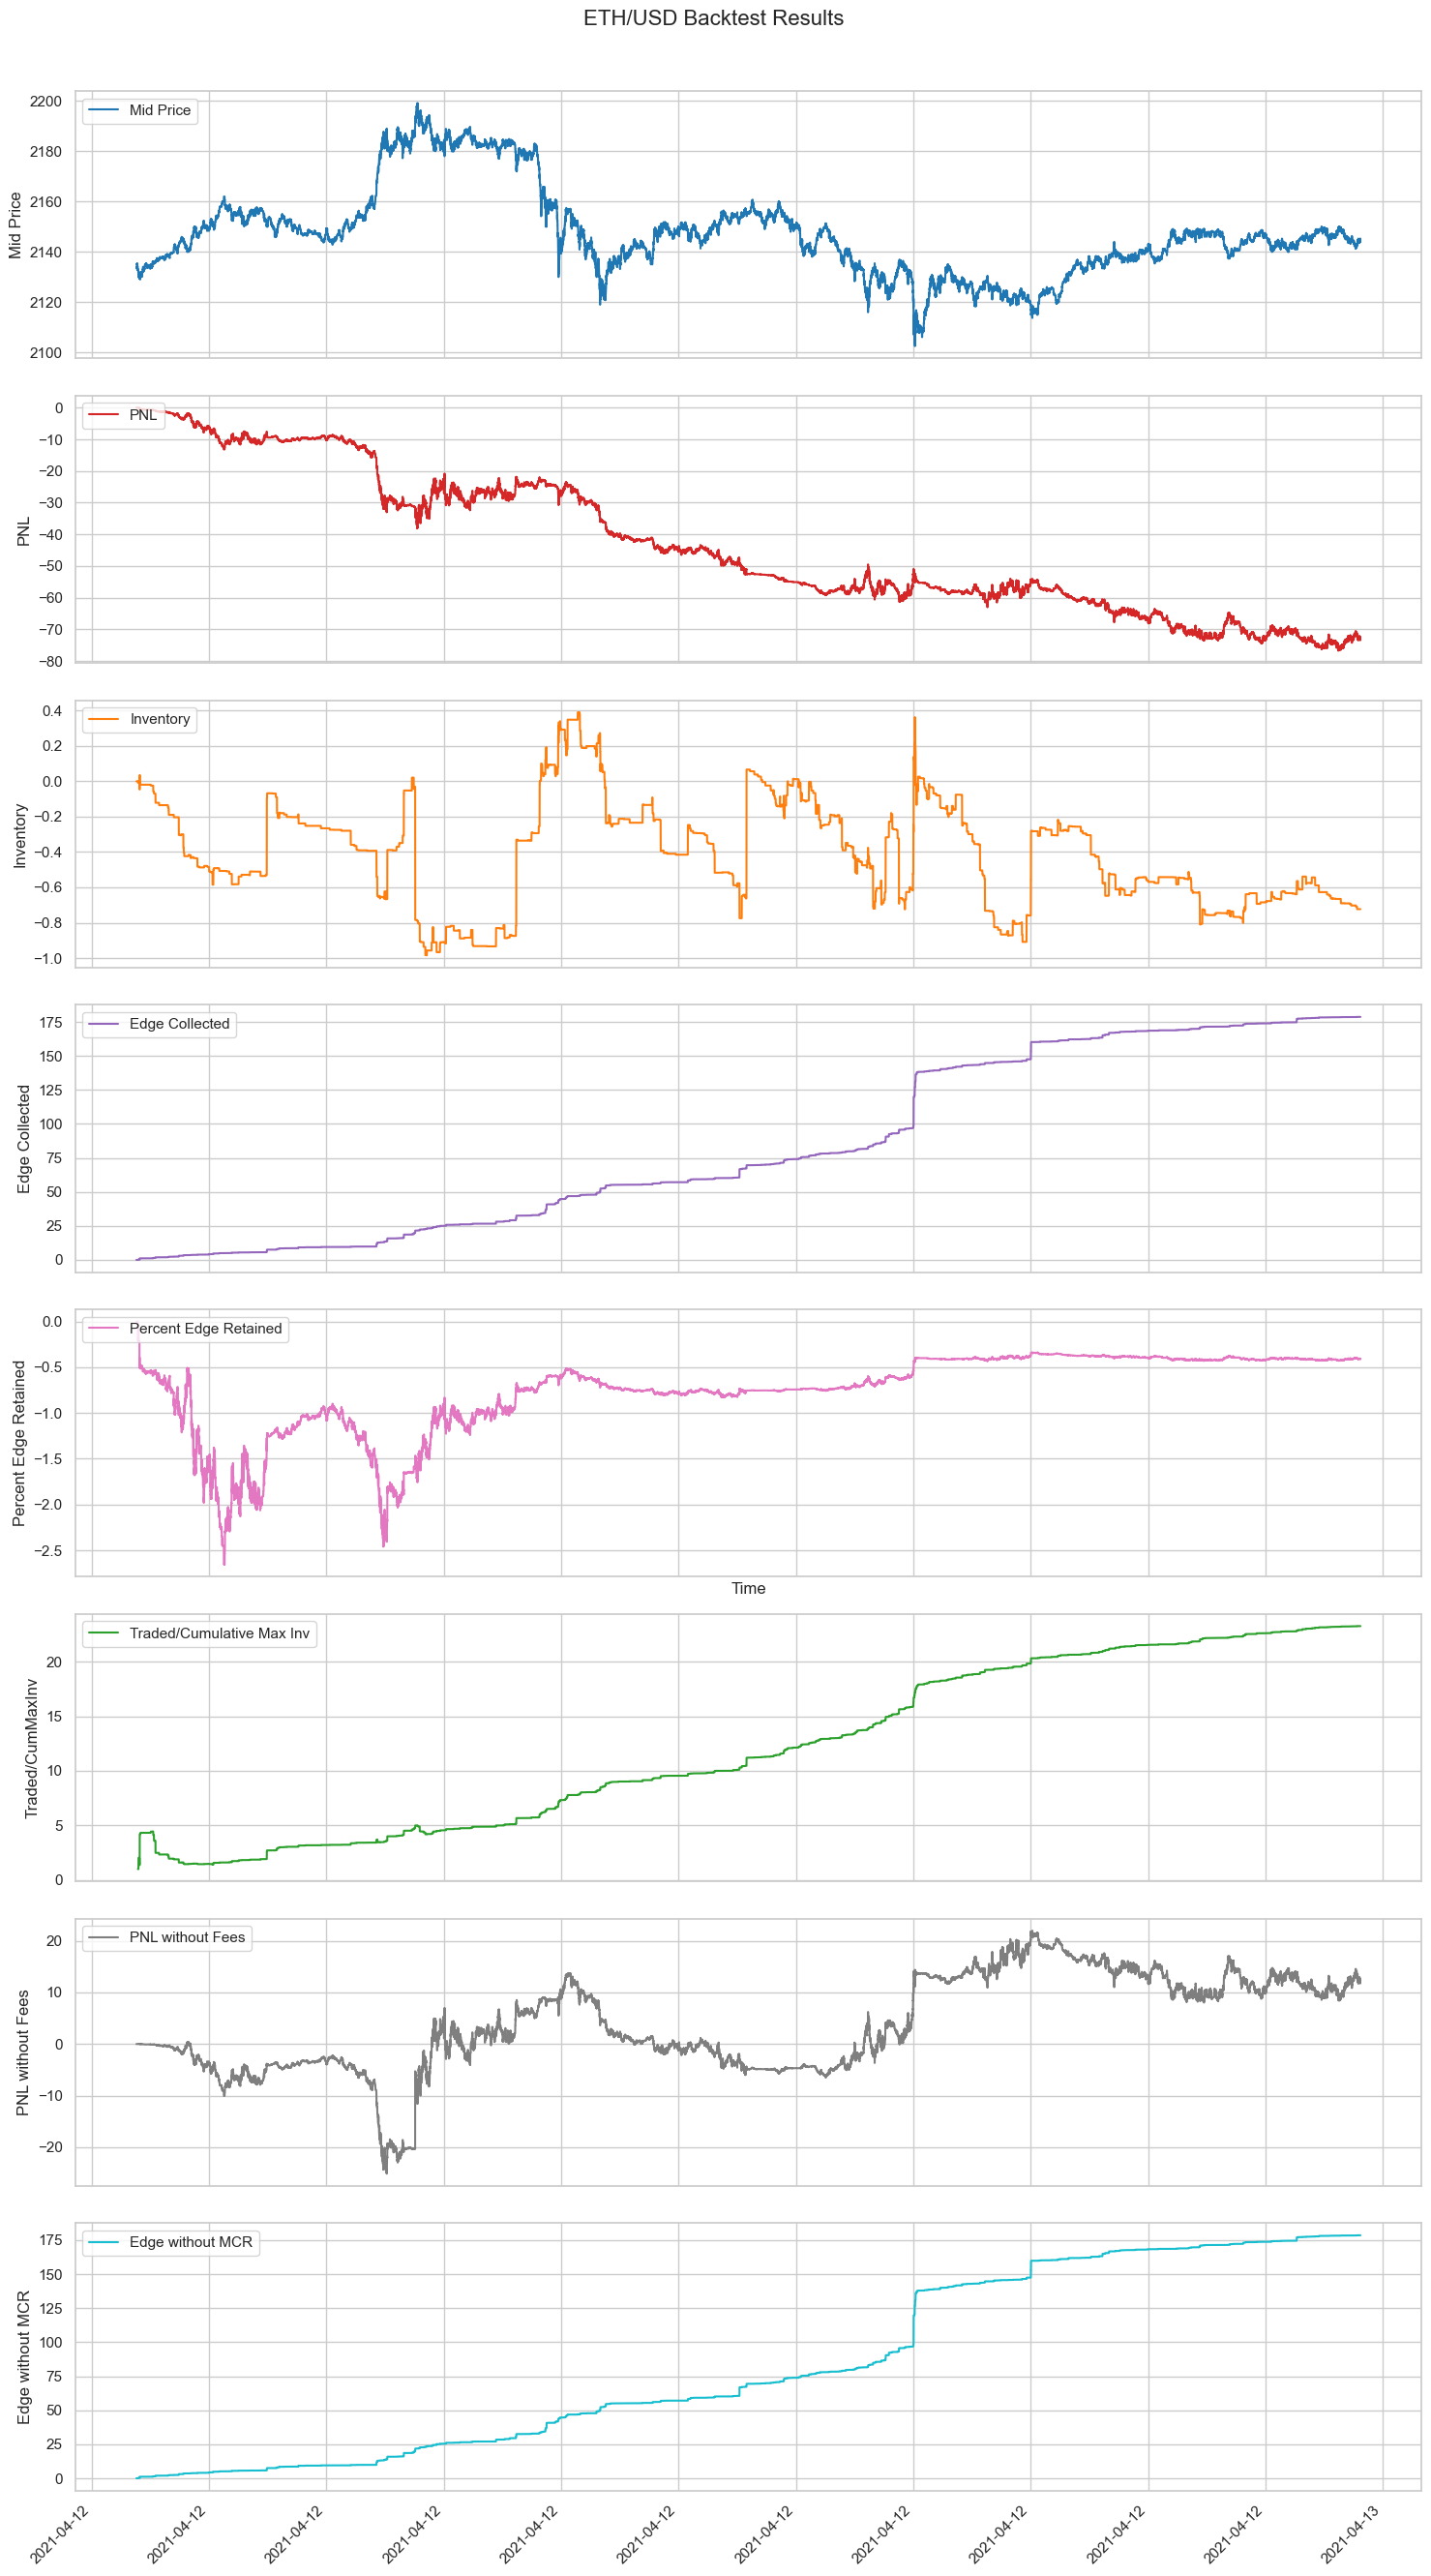

Mean                     -9.70946e-09
Annualized_mean          -3.06197e-01
Volatility                1.22465e-06
Annualized_Volatility     6.87727e-03
Sharpe_Ratio             -7.92834e-03
Annualized_Sharpe        -4.45231e+01
Skewness                 -1.03272e+00
Excess_Kurtosis           2.70671e+01
VaR (0.05)               -1.60729e-06
CVaR (0.05)              -3.28019e-06
Min                      -2.17294e-05
Max                       1.46016e-05
Max Drawdown             -7.67357e-04
Peak                              .5e
Bottom                            .5e
Recovery                          .5e
dtype: object

In [44]:
plot_backtest_results(adj_tot_ETH_USD_backtest_data, title='ETH/USD Backtest Results')
return_data = adj_reg_ETH_USD_backtest_data['PNL'].diff()/capital
return_data.mean()
display(performance_summary(return_data))

# 9) Parameter Tuning

## 9.1) Split Data

In [36]:
columns_to_keep = ["ask_price_1","bid_price_1","ask_size_1","bid_size_1","ask_price_2","bid_price_2","ask_size_2","bid_size_2","mid","share_imbalance","MKT_Theo"]


# First, combine them:
ETH_USD_book_combined = pd.concat([ETH_USD_book_train_cpy[columns_to_keep], ETH_USD_book_test_cpy[columns_to_keep]])
ETH_BTC_book_combined = pd.concat([ETH_BTC_book_train_cpy[columns_to_keep], ETH_BTC_book_test_cpy[columns_to_keep]])
ETH_USD_trades_combined = pd.concat([ETH_USD_trades_train_cpy, ETH_USD_trades_test_cpy])
ETH_BTC_trades_combined = pd.concat([ETH_BTC_trades_train_cpy, ETH_BTC_trades_test_cpy])

# Sort by date index if necessary (assuming the date is the level 0 of a MultiIndex)
ETH_USD_book_combined.sort_index(level=0, inplace=True)
ETH_BTC_book_combined.sort_index(level=0, inplace=True)
ETH_USD_trades_combined.sort_index(level=0, inplace=True)
ETH_BTC_trades_combined.sort_index(level=0, inplace=True)

def calculate_split_dates(combined_df):
    total_length = len(combined_df)
    split_index_1 = int(total_length * 0.4)  # 40%
    split_index_2 = int(total_length * 0.7)  # 40% + 30% = 70%

    # Corrected to directly use the Timestamp object
    date_for_hyper_test_start = combined_df.iloc[split_index_1].name
    date_for_test_start = combined_df.iloc[split_index_2].name

    # If the DataFrame uses a MultiIndex and date is at level 0, adjust like so:
    # date_for_hyper_test_start = combined_df.index.get_level_values(0)[split_index_1]
    # date_for_test_start = combined_df.index.get_level_values(0)[split_index_2]

    return (date_for_hyper_test_start, date_for_test_start)


# Calculate split dates for ETH_USD and ETH_BTC
split_dates_ETH_USD = calculate_split_dates(ETH_USD_book_combined)
split_dates_ETH_BTC = calculate_split_dates(ETH_BTC_book_combined)

# Now, use the three_way_split_by_date function for ETH_USD
ETH_USD_book_train, ETH_USD_book_hyper_test, ETH_USD_book_test, ETH_USD_trades_train, ETH_USD_trades_hyper_test, ETH_USD_trades_test = \
    three_way_split_by_date(ETH_USD_book_combined, ETH_USD_trades_combined, "ETH_USD", split_dates_ETH_USD, display_data=False)

# And for ETH_BTC
ETH_BTC_book_train, ETH_BTC_book_hyper_test, ETH_BTC_book_test, ETH_BTC_trades_train, ETH_BTC_trades_hyper_test, ETH_BTC_trades_test = \
    three_way_split_by_date(ETH_BTC_book_combined, ETH_BTC_trades_combined, "ETH_BTC", split_dates_ETH_BTC, display_data=False)

check_dataframe_integrity(ETH_USD_book_train,False,True)
check_dataframe_integrity(ETH_USD_book_hyper_test,False,True)
check_dataframe_integrity(ETH_USD_book_test,False,True)

check_dataframe_integrity(ETH_BTC_book_train,False,True)
check_dataframe_integrity(ETH_BTC_book_hyper_test,False,True)
check_dataframe_integrity(ETH_BTC_book_test,False,True)


check_dataframe_integrity(ETH_USD_trades_train,False,True)
check_dataframe_integrity(ETH_USD_trades_hyper_test,False,True)
check_dataframe_integrity(ETH_USD_trades_test,False,True)

check_dataframe_integrity(ETH_BTC_trades_train,False,True)
check_dataframe_integrity(ETH_BTC_trades_hyper_test,False,True)
check_dataframe_integrity(ETH_BTC_trades_test,False,True)

Check for uniqueness:                True
Check for excessively large numbers: Passed
Check for NaN values:                Passed


,ask_price_1,bid_price_1,ask_size_1,bid_size_1,ask_price_2,bid_price_2,ask_size_2,bid_size_2,mid,share_imbalance,MKT_Theo
time,,,,,,,,,,,
2021-04-10 21:28:54.547039,2109.00,2108.99,14.095270,9.377656,2109.03,2108.98,6.45344,3.000000,2108.995,0.399509,2108.993406
2021-04-10 21:28:54.563411,2109.00,2108.99,14.095270,9.377656,2109.03,2108.97,6.45344,2.010700,2108.995,0.399509,2108.992993
2021-04-10 21:28:54.797956,2109.00,2108.99,14.059061,9.377656,2109.03,2108.97,6.45344,2.010700,2108.995,0.400127,2108.993005
2021-04-10 21:28:55.123831,2109.00,2108.99,13.559561,9.377656,2109.03,2108.97,6.45344,2.010700,2108.995,0.408840,2108.993182
2021-04-10 21:28:55.368753,2109.00,2108.99,13.559561,9.277578,2109.03,2108.97,6.45344,2.010700,2108.995,0.406250,2108.993130
...,...,...,...,...,...,...,...,...,...,...,...
2021-04-11 16:02:59.009575,2148.43,2148.25,3.000000,4.100000,2148.46,2148.21,15.00000,0.783377,2148.340,0.577465,2148.340000
2021-04-11 16:02:59.010990,2148.43,2148.25,3.000000,4.100000,2148.46,2148.21,15.00000,21.633377,2148.340,0.577465,2148.340912
2021-04-11 16:02:59.011099,2148.43,2148.25,3.000000,4.100000,2148.46,2148.21,15.00000,21.633377,2148.340,0.577465,2148.340912


Check for uniqueness:                True
Check for excessively large numbers: Passed
Check for NaN values:                Passed


,ask_price_1,bid_price_1,ask_size_1,bid_size_1,ask_price_2,bid_price_2,ask_size_2,bid_size_2,mid,share_imbalance,MKT_Theo
time,,,,,,,,,,,
2021-04-11 16:02:59.012139,2148.43,2148.21,3.000000,24.95000,2148.46,2148.20,15.000000,3.454065,2148.320,0.892665,2148.330280
2021-04-11 16:02:59.013806,2148.43,2148.21,3.000000,24.95000,2148.46,2148.20,15.776024,3.454065,2148.320,0.892665,2148.330233
2021-04-11 16:02:59.013872,2148.22,2148.21,0.523710,24.95000,2148.43,2148.20,3.000000,3.454065,2148.215,0.979441,2148.234574
2021-04-11 16:02:59.015430,2148.22,2148.21,0.523710,24.95000,2148.46,2148.20,15.776024,3.454065,2148.215,0.979441,2148.234574
2021-04-11 16:02:59.016201,2148.22,2148.21,0.523710,20.85000,2148.46,2148.20,15.776024,3.454065,2148.215,0.975497,2148.233721
...,...,...,...,...,...,...,...,...,...,...,...
2021-04-12 08:01:48.053247,2186.17,2185.95,4.100000,0.58000,2186.19,2185.84,9.216017,0.523710,2186.060,0.123932,2186.048429
2021-04-12 08:01:48.060841,2186.17,2185.95,4.100000,0.58000,2186.19,2185.83,9.216017,0.100068,2186.060,0.123932,2186.048429
2021-04-12 08:01:48.064567,2186.17,2185.95,4.100000,0.58000,2186.19,2185.94,9.216017,0.580000,2186.060,0.123932,2186.049894


Check for uniqueness:                True
Check for excessively large numbers: Passed
Check for NaN values:                Passed


,ask_price_1,bid_price_1,ask_size_1,bid_size_1,ask_price_2,bid_price_2,ask_size_2,bid_size_2,mid,share_imbalance,MKT_Theo
time,,,,,,,,,,,
2021-04-12 08:01:48.187365,2186.19,2185.96,13.316017,0.52371,2186.20,2185.95,9.149564,0.580000,2186.075,0.037841,2186.059375
2021-04-12 08:01:48.191566,2186.16,2185.96,3.000000,0.52371,2186.19,2185.95,13.316017,0.580000,2186.060,0.148625,2186.051272
2021-04-12 08:01:48.198066,2186.16,2185.95,3.000000,0.58000,2186.19,2185.94,13.316017,0.580000,2186.055,0.162011,2186.046593
2021-04-12 08:01:48.207176,2186.16,2185.96,3.000000,0.52371,2186.19,2185.95,13.316017,0.580000,2186.060,0.148625,2186.051272
2021-04-12 08:01:48.213516,2186.16,2185.95,3.000000,0.58000,2186.19,2185.94,13.316017,0.580000,2186.055,0.162011,2186.046593
...,...,...,...,...,...,...,...,...,...,...,...
2021-04-12 23:36:57.833449,2144.45,2144.44,1.460000,38.57371,2144.46,2144.37,1.460000,17.208192,2144.445,0.963531,2144.459849
2021-04-12 23:36:57.839855,2144.45,2144.44,1.460000,38.57371,2144.46,2144.37,1.460000,17.208192,2144.445,0.963531,2144.459849
2021-04-12 23:36:57.839933,2144.45,2144.44,1.460000,38.57371,2144.46,2144.37,1.460000,17.208192,2144.445,0.963531,2144.459849


Check for uniqueness:                True
Check for excessively large numbers: Passed
Check for NaN values:                Passed


,ask_price_1,bid_price_1,ask_size_1,bid_size_1,ask_price_2,bid_price_2,ask_size_2,bid_size_2,mid,share_imbalance,MKT_Theo
time,,,,,,,,,,,
2021-04-10 21:28:55.799659,0.03570,0.03569,11.872084,32.957204,0.03571,0.03568,31.032423,45.284575,0.035695,0.735171,0.035699
2021-04-10 21:28:56.388074,0.03570,0.03569,11.872084,32.957204,0.03571,0.03568,30.332423,45.284575,0.035695,0.735171,0.035699
2021-04-10 21:28:57.078119,0.03570,0.03569,11.872084,32.957204,0.03571,0.03568,22.332423,45.284575,0.035695,0.735171,0.035700
2021-04-10 21:28:57.082698,0.03570,0.03569,11.872084,32.957204,0.03571,0.03568,22.332423,45.284575,0.035695,0.735171,0.035700
2021-04-10 21:28:57.157544,0.03570,0.03569,11.872084,32.956204,0.03571,0.03568,22.332423,45.284575,0.035695,0.735165,0.035700
...,...,...,...,...,...,...,...,...,...,...,...
2021-04-11 17:44:49.300137,0.03587,0.03586,41.387763,8.121205,0.03588,0.03585,72.102167,9.696476,0.035865,0.164035,0.035856
2021-04-11 17:44:49.415074,0.03587,0.03586,41.387763,8.121205,0.03588,0.03585,67.202167,9.696476,0.035865,0.164035,0.035856
2021-04-11 17:44:49.475915,0.03587,0.03586,41.387763,8.121205,0.03588,0.03585,65.016910,9.696476,0.035865,0.164035,0.035856


Check for uniqueness:                True
Check for excessively large numbers: Passed
Check for NaN values:                Passed


,ask_price_1,bid_price_1,ask_size_1,bid_size_1,ask_price_2,bid_price_2,ask_size_2,bid_size_2,mid,share_imbalance,MKT_Theo
time,,,,,,,,,,,
2021-04-11 17:44:49.542013,0.03587,0.03586,41.387763,7.480563,0.03588,0.03585,28.420310,10.337117,0.035865,0.153076,0.035857
2021-04-11 17:44:49.578233,0.03587,0.03586,41.387763,7.480563,0.03588,0.03585,28.420310,10.337117,0.035865,0.153076,0.035857
2021-04-11 17:44:49.589777,0.03587,0.03586,41.387763,7.480563,0.03588,0.03585,28.420310,10.337117,0.035865,0.153076,0.035857
2021-04-11 17:44:49.606118,0.03587,0.03586,41.387763,7.480563,0.03588,0.03585,27.449085,10.337117,0.035865,0.153076,0.035857
2021-04-11 17:44:49.633143,0.03587,0.03586,41.387763,7.480563,0.03588,0.03585,64.045685,10.337117,0.035865,0.153076,0.035856
...,...,...,...,...,...,...,...,...,...,...,...
2021-04-12 09:38:41.658452,0.03583,0.03581,69.151589,21.744702,0.03584,0.03580,22.337455,46.213356,0.035820,0.239225,0.035817
2021-04-12 09:38:41.667703,0.03583,0.03581,70.299748,21.744702,0.03584,0.03580,22.337455,46.213356,0.035820,0.236241,0.035816
2021-04-12 09:38:41.678951,0.03583,0.03581,70.299748,21.744702,0.03584,0.03580,22.337455,47.679481,0.035820,0.236241,0.035817


Check for uniqueness:                True
Check for excessively large numbers: Passed
Check for NaN values:                Passed


,ask_price_1,bid_price_1,ask_size_1,bid_size_1,ask_price_2,bid_price_2,ask_size_2,bid_size_2,mid,share_imbalance,MKT_Theo
time,,,,,,,,,,,
2021-04-12 09:38:41.794994,0.03583,0.03581,71.373714,23.344702,0.03584,0.03580,22.337455,46.079481,0.035820,0.246464,0.035817
2021-04-12 09:38:41.939570,0.03583,0.03581,71.373714,21.744702,0.03584,0.03580,22.337455,46.079481,0.035820,0.233517,0.035816
2021-04-12 09:38:41.944454,0.03583,0.03581,71.373714,21.744702,0.03584,0.03580,22.337455,47.679481,0.035820,0.233517,0.035816
2021-04-12 09:38:41.955333,0.03583,0.03581,71.373714,21.744702,0.03584,0.03580,22.337455,46.079481,0.035820,0.233517,0.035816
2021-04-12 09:38:41.959272,0.03583,0.03581,71.373714,23.344702,0.03584,0.03580,22.337455,46.079481,0.035820,0.246464,0.035817
...,...,...,...,...,...,...,...,...,...,...,...
2021-04-12 23:36:57.292351,0.03577,0.03576,1.255039,24.752613,0.03578,0.03575,72.437618,41.785631,0.035765,0.951743,0.035767
2021-04-12 23:36:57.792847,0.03577,0.03576,1.255039,24.752613,0.03578,0.03575,35.841018,41.785631,0.035765,0.951743,0.035770
2021-04-12 23:36:57.822640,0.03577,0.03576,1.255039,24.752613,0.03578,0.03575,31.011777,41.785631,0.035765,0.951743,0.035771


Check for uniqueness:                False
Check for excessively large numbers: Passed
Check for NaN values:                Passed


,price,size
time,,
2021-04-10 21:28:54.547039,2109.00,0.499500
2021-04-10 21:28:54.797956,2109.00,0.036209
2021-04-10 21:28:55.123831,2109.00,0.499500
2021-04-10 21:28:55.704667,2109.00,0.499400
2021-04-10 21:28:56.302068,2109.00,0.499400
...,...,...
2021-04-11 16:02:56.228659,2149.11,0.009260
2021-04-11 16:02:57.012713,2149.19,0.022240
2021-04-11 16:02:57.205211,2149.16,0.010890


Check for uniqueness:                False
Check for excessively large numbers: Passed
Check for NaN values:                Passed


,price,size
time,,
2021-04-11 16:02:59.032132,2148.83,0.010890
2021-04-11 16:02:59.266934,2148.76,0.022233
2021-04-11 16:03:00.703387,2148.50,-0.163778
2021-04-11 16:03:00.817893,2148.72,0.004654
2021-04-11 16:03:01.067392,2148.52,0.523710
...,...,...
2021-04-12 08:01:43.040441,2186.27,0.962246
2021-04-12 08:01:45.134022,2186.32,0.010703
2021-04-12 08:01:46.438535,2185.98,-0.523710


Check for uniqueness:                False
Check for excessively large numbers: Passed
Check for NaN values:                Passed


,price,size
time,,
2021-04-12 08:01:48.403908,2186.15,-0.069835
2021-04-12 08:01:48.528086,2186.16,0.008429
2021-04-12 08:01:50.294561,2186.28,-0.302816
2021-04-12 08:01:50.702251,2186.23,0.224312
2021-04-12 08:01:51.247535,2186.27,0.002671
...,...,...
2021-04-12 23:36:54.708505,2144.47,0.523710
2021-04-12 23:36:54.708505,2144.48,0.390539
2021-04-12 23:36:54.883348,2144.47,0.091400


Check for uniqueness:                False
Check for excessively large numbers: Passed
Check for NaN values:                Passed


,price,size
time,,
2021-04-10 21:28:57.157544,0.03569,-0.001000
2021-04-10 21:28:57.864544,0.03570,0.029802
2021-04-10 21:29:03.793909,0.03570,0.004641
2021-04-10 21:29:15.053606,0.03571,0.001000
2021-04-10 21:29:15.053606,0.03572,0.231356
...,...,...
2021-04-11 17:44:31.257899,0.03585,-0.021755
2021-04-11 17:44:41.368684,0.03587,0.155204
2021-04-11 17:44:42.133527,0.03587,0.002819


Check for uniqueness:                False
Check for excessively large numbers: Passed
Check for NaN values:                Passed


,price,size
time,,
2021-04-11 17:44:57.641545,0.03587,0.061859
2021-04-11 17:44:59.462146,0.03587,0.204386
2021-04-11 17:45:03.232330,0.03587,0.182768
2021-04-11 17:45:15.592900,0.03587,0.003117
2021-04-11 17:45:15.735267,0.03587,0.043833
...,...,...
2021-04-12 09:38:23.725186,0.03582,0.021183
2021-04-12 09:38:26.475921,0.03581,-0.017482
2021-04-12 09:38:26.498927,0.03581,-0.330590


Check for uniqueness:                False
Check for excessively large numbers: Passed
Check for NaN values:                Passed


,price,size
time,,
2021-04-12 09:38:46.411840,0.03581,-0.062209
2021-04-12 09:38:48.194560,0.03582,1.058314
2021-04-12 09:38:48.194560,0.03583,2.540758
2021-04-12 09:38:51.356574,0.03582,-0.115012
2021-04-12 09:38:52.349728,0.03582,-14.090000
...,...,...
2021-04-12 23:36:49.550910,0.03578,0.006918
2021-04-12 23:36:49.930738,0.03578,0.182922
2021-04-12 23:36:50.482336,0.03578,0.004577


## 9.2) Indicator Parameter Tuner

### 9.2.1) ETH/USD

In [37]:
volume_halflife_list= [500]#np.linspace(start=500, stop=15000, num=4, dtype=int)  # From 10 to 60, 6 values
flow_halflife_list= [500]#np.linspace(start=500, stop=15000, num=4, dtype=int)  # Same for flow_halflife, for consistency
t_list = [1000]#[5, 10 , 100, 300, 500, 800, 1000]# np.linspace(start=5, stop=10000, num=10, dtype=int)
rolling_z_score_window_list= [50]#np.linspace(start=50, stop=50, num=1, dtype=int)


ETH_USD_ind_best_params, ETH_USD_best_backtest_df, ETH_USD_best_MSE, ETH_USD_all_MSE = indicator_hyperparameter_tuner(
    ETH_USD_trades_train,
    ETH_USD_trades_hyper_test,
    ETH_USD_book_train,
    ETH_USD_book_hyper_test, 
    ETH_BTC_trades_train,
    ETH_BTC_trades_hyper_test,
    "ETH_USD",
    volume_halflife_list,
    flow_halflife_list,
    t_list,
    rolling_z_score_window_list,
    2
)

(500, 500, 1000, 50)

1

174.30065048619178

174.30065048619178

In [38]:
print("Best Parameters:", ETH_USD_ind_best_params)
print("Best MSE:", ETH_USD_best_MSE)
print("All MSE values:", ETH_USD_all_MSE.sort())
display(ETH_USD_best_backtest_df)

Best Parameters: {'volume_halflife': 500, 'flow_halflife': 500, 'T': 1000, 'rolling_z_score_window': 50}
Best MSE: 174.30065048619178
All MSE values: None


,price,size,MKT_Theo,y_hat
time,,,,
2021-04-11 17:44:57.762415999,2144.16,0.104542,2144.14,-0.243997
2021-04-11 17:44:58.317369999,2144.07,-0.556113,2144.10,0.144429
2021-04-11 17:44:58.336979999,2144.14,0.091421,2144.10,0.139949
2021-04-11 17:44:59.423871999,2144.16,0.025063,2144.11,-0.206245
2021-04-11 17:45:00.475311999,2144.16,0.275647,2144.13,-0.269048
...,...,...,...,...
2021-04-12 08:01:43.040440999,2186.27,0.962246,2185.99,0.192198
2021-04-12 08:01:45.134021999,2186.32,0.010703,2186.21,-0.157449
2021-04-12 08:01:46.438534999,2185.98,-0.523710,2186.14,-0.054598


## 9.3) Strategy Parameter Tuner

### 9.3.1) ETH/USD

In [39]:
trading_cost = 0.0015  # Example trading cost, adjust to your scenario
capital = 100000  # Example capital, adjust to your scenario

min_edge_multipliers = [1,3]
min_size_multipliers = [0.0001, 0.001]
max_size_multipliers = [0.005, 0.03]
mcr_multipliers = [5.0,25.0,50.0]
slope_values = [] 


display(ETH_USD_best_backtest_df)
# Call the grid search hyperparameter tuner function
ETH_USD_strat_best_params, ETH_USD_best_performance = strategy_hyperparameter_tuner(
    backtest_df=ETH_USD_best_backtest_df,
    book_test_cpy=ETH_USD_book_test_cpy,
    trading_cost=trading_cost,
    capital=capital
)

,price,size,MKT_Theo,y_hat
time,,,,
2021-04-11 17:44:57.762415999,2144.16,0.104542,2144.14,-0.243997
2021-04-11 17:44:58.317369999,2144.07,-0.556113,2144.10,0.144429
2021-04-11 17:44:58.336979999,2144.14,0.091421,2144.10,0.139949
2021-04-11 17:44:59.423871999,2144.16,0.025063,2144.11,-0.206245
2021-04-11 17:45:00.475311999,2144.16,0.275647,2144.13,-0.269048
...,...,...,...,...
2021-04-12 08:01:43.040440999,2186.27,0.962246,2185.99,0.192198
2021-04-12 08:01:45.134021999,2186.32,0.010703,2186.21,-0.157449
2021-04-12 08:01:46.438534999,2185.98,-0.523710,2186.14,-0.054598


3.21624
0.004663831057383778
0.23319155286918888
0.0007250440043939161
25.0


c:\Users\jackm\OneDrive\Desktop\MSFM\QTS\Final_Project\QTS_Final_Project\Utilities.py:618: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


sharp:


-0.0375327

1

3.21624
0.004663831057383778
0.23319155286918888
0.0014500880087878322
25.0


c:\Users\jackm\OneDrive\Desktop\MSFM\QTS\Final_Project\QTS_Final_Project\Utilities.py:618: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


sharp:


-0.0441097

2

3.21624
0.004663831057383778
0.23319155286918888
0.0021751320131817484
25.0


c:\Users\jackm\OneDrive\Desktop\MSFM\QTS\Final_Project\QTS_Final_Project\Utilities.py:618: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


sharp:


-0.0499527

3

3.21624
0.004663831057383778
1.3991493172151332
0.0007250440043939161
25.0


c:\Users\jackm\OneDrive\Desktop\MSFM\QTS\Final_Project\QTS_Final_Project\Utilities.py:618: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


sharp:


-0.0375327

4

3.21624
0.004663831057383778
1.3991493172151332
0.0014500880087878322
25.0


c:\Users\jackm\OneDrive\Desktop\MSFM\QTS\Final_Project\QTS_Final_Project\Utilities.py:618: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


sharp:


-0.0441097

5

3.21624
0.004663831057383778
1.3991493172151332
0.0021751320131817484
25.0


c:\Users\jackm\OneDrive\Desktop\MSFM\QTS\Final_Project\QTS_Final_Project\Utilities.py:618: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


sharp:


-0.0499527

6

3.21624
0.04663831057383778
0.23319155286918888
0.007250440043939162
25.0


c:\Users\jackm\OneDrive\Desktop\MSFM\QTS\Final_Project\QTS_Final_Project\Utilities.py:618: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


sharp:


-0.0926093

7

3.21624
0.04663831057383778
0.23319155286918888
0.014500880087878323
25.0


c:\Users\jackm\OneDrive\Desktop\MSFM\QTS\Final_Project\QTS_Final_Project\Utilities.py:618: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


sharp:


-0.0959874

8

3.21624
0.04663831057383778
0.23319155286918888
0.021751320131817485
25.0


c:\Users\jackm\OneDrive\Desktop\MSFM\QTS\Final_Project\QTS_Final_Project\Utilities.py:618: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


sharp:


-0.0982261

9

3.21624
0.04663831057383778
1.3991493172151332
0.007250440043939162
25.0


c:\Users\jackm\OneDrive\Desktop\MSFM\QTS\Final_Project\QTS_Final_Project\Utilities.py:618: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


sharp:


-0.0926093

10

3.21624
0.04663831057383778
1.3991493172151332
0.014500880087878323
25.0


c:\Users\jackm\OneDrive\Desktop\MSFM\QTS\Final_Project\QTS_Final_Project\Utilities.py:618: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


sharp:


-0.0958431

11

3.21624
0.04663831057383778
1.3991493172151332
0.021751320131817485
25.0


c:\Users\jackm\OneDrive\Desktop\MSFM\QTS\Final_Project\QTS_Final_Project\Utilities.py:618: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


sharp:


-0.0980434

12

9.64872
0.004663831057383778
0.23319155286918888
0.00024168133479797203
25.0


c:\Users\jackm\OneDrive\Desktop\MSFM\QTS\Final_Project\QTS_Final_Project\Utilities.py:618: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


sharp:


-0.0166537

13

9.64872
0.004663831057383778
0.23319155286918888
0.00048336266959594405
25.0


c:\Users\jackm\OneDrive\Desktop\MSFM\QTS\Final_Project\QTS_Final_Project\Utilities.py:618: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


sharp:


-0.0192334

14

9.64872
0.004663831057383778
0.23319155286918888
0.0007250440043939161
25.0


c:\Users\jackm\OneDrive\Desktop\MSFM\QTS\Final_Project\QTS_Final_Project\Utilities.py:618: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


sharp:


-0.0224939

15

9.64872
0.004663831057383778
1.3991493172151332
0.00024168133479797203
25.0


c:\Users\jackm\OneDrive\Desktop\MSFM\QTS\Final_Project\QTS_Final_Project\Utilities.py:618: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


sharp:


-0.0166537

16

9.64872
0.004663831057383778
1.3991493172151332
0.00048336266959594405
25.0


c:\Users\jackm\OneDrive\Desktop\MSFM\QTS\Final_Project\QTS_Final_Project\Utilities.py:618: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


sharp:


-0.0192334

17

9.64872
0.004663831057383778
1.3991493172151332
0.0007250440043939161
25.0


c:\Users\jackm\OneDrive\Desktop\MSFM\QTS\Final_Project\QTS_Final_Project\Utilities.py:618: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


sharp:


-0.0224939

18

9.64872
0.04663831057383778
0.23319155286918888
0.0024168133479797204
25.0


c:\Users\jackm\OneDrive\Desktop\MSFM\QTS\Final_Project\QTS_Final_Project\Utilities.py:618: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


sharp:


-0.0167317

19

9.64872
0.04663831057383778
0.23319155286918888
0.004833626695959441
25.0


c:\Users\jackm\OneDrive\Desktop\MSFM\QTS\Final_Project\QTS_Final_Project\Utilities.py:618: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


sharp:


-0.0159016

20

9.64872
0.04663831057383778
0.23319155286918888
0.007250440043939162
25.0


c:\Users\jackm\OneDrive\Desktop\MSFM\QTS\Final_Project\QTS_Final_Project\Utilities.py:618: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


sharp:


-0.0134915

21

9.64872
0.04663831057383778
1.3991493172151332
0.0024168133479797204
25.0


c:\Users\jackm\OneDrive\Desktop\MSFM\QTS\Final_Project\QTS_Final_Project\Utilities.py:618: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


sharp:


-0.0167317

22

9.64872
0.04663831057383778
1.3991493172151332
0.004833626695959441
25.0


c:\Users\jackm\OneDrive\Desktop\MSFM\QTS\Final_Project\QTS_Final_Project\Utilities.py:618: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


sharp:


-0.0159016

23

9.64872
0.04663831057383778
1.3991493172151332
0.007250440043939162
25.0


c:\Users\jackm\OneDrive\Desktop\MSFM\QTS\Final_Project\QTS_Final_Project\Utilities.py:618: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


sharp:


-0.0134915

24



In [40]:
display("Best Parameters:", ETH_USD_strat_best_params)
ETH_USD_final_pnl, ETH_USD_adj_tot_backtest_data, ETH_USD_adj_reg_backtest_data, ETH_USD_adj_tot_book_test, ETH_USD_adj_reg_book_test = ETH_USD_best_performance
print("Best Final PnL:", ETH_USD_final_pnl)

'Best Parameters:'

{'min_edge': 9.64872,
 'min_size': 0.04663831057383778,
 'max_size': 0.23319155286918888,
 'mcr_multiplier': 25.0,
 'slope': 0.007250440043939162}

Best Final PnL: -22.925706482534792


# 10) Final Results

## 10.1) Create Final Train and Test set

In [41]:
# First, combine them:
ETH_USD_book_train = pd.concat([ETH_USD_book_train, ETH_USD_book_hyper_test])
ETH_BTC_book_train = pd.concat([ETH_BTC_book_train, ETH_BTC_book_hyper_test])
ETH_USD_trades_train = pd.concat([ETH_USD_trades_train, ETH_USD_trades_hyper_test])
ETH_BTC_trades_train = pd.concat([ETH_BTC_trades_train, ETH_BTC_trades_hyper_test])

# Sort by date index if necessary (assuming the date is the level 0 of a MultiIndex)
ETH_USD_book_train.sort_index(level=0, inplace=True)
ETH_BTC_book_train.sort_index(level=0, inplace=True)
ETH_USD_trades_train.sort_index(level=0, inplace=True)
ETH_BTC_trades_train.sort_index(level=0, inplace=True)

check_dataframe_integrity(ETH_USD_book_train,False,False)
check_dataframe_integrity(ETH_USD_book_test,False,False)

check_dataframe_integrity(ETH_USD_trades_train,False,False)
check_dataframe_integrity(ETH_USD_trades_test,False,False)

Check for uniqueness:                True
Check for excessively large numbers: Passed
Check for NaN values:                Passed


Check for uniqueness:                True
Check for excessively large numbers: Passed
Check for NaN values:                Passed
Check for uniqueness:                False
Check for excessively large numbers: Passed
Check for NaN values:                Passed
Check for uniqueness:                False
Check for excessively large numbers: Passed
Check for NaN values:                Passed


# 10.2) Run Strategies

In [42]:
ETH_USD_ind_best_params = {'volume_halflife': 500, 'flow_halflife': 500, 'T': 1000, 'rolling_z_score_window': 50}

ETH_USD_strat_best_params ={'min_edge': 3.21624,
 'min_size': 0.04663831057383778,
 'max_size': 1.3991493172151332,
 'mcr_multiplier': 30.0,
 'slope': 0.017401056105453987}

final_pnl, ETH_USD_adj_tot_backtest_data, ETH_USD_adj_reg_backtest_data, ETH_USD_adj_tot_book_test, ETH_USD_adj_reg_book_test = full_backtest_process(
    trade_data_train=ETH_USD_trades_train,
    trade_data_test=ETH_USD_trades_test,
    book_data_train=ETH_USD_book_train,
    book_data_test=ETH_USD_book_test,
    cross_trade_data_train=ETH_BTC_trades_train,
    cross_trade_data_test=ETH_BTC_trades_test,
    strat_params=ETH_USD_strat_best_params,
    ind_params=ETH_USD_ind_best_params
)


3.21624
0.04663831057383778
1.3991493172151332
0.017401056105453987
30.0


c:\Users\jackm\OneDrive\Desktop\MSFM\QTS\Final_Project\QTS_Final_Project\Utilities.py:618: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Best Final PnL: -1133.8386853742177


## 10.3) ETH/USD Results 

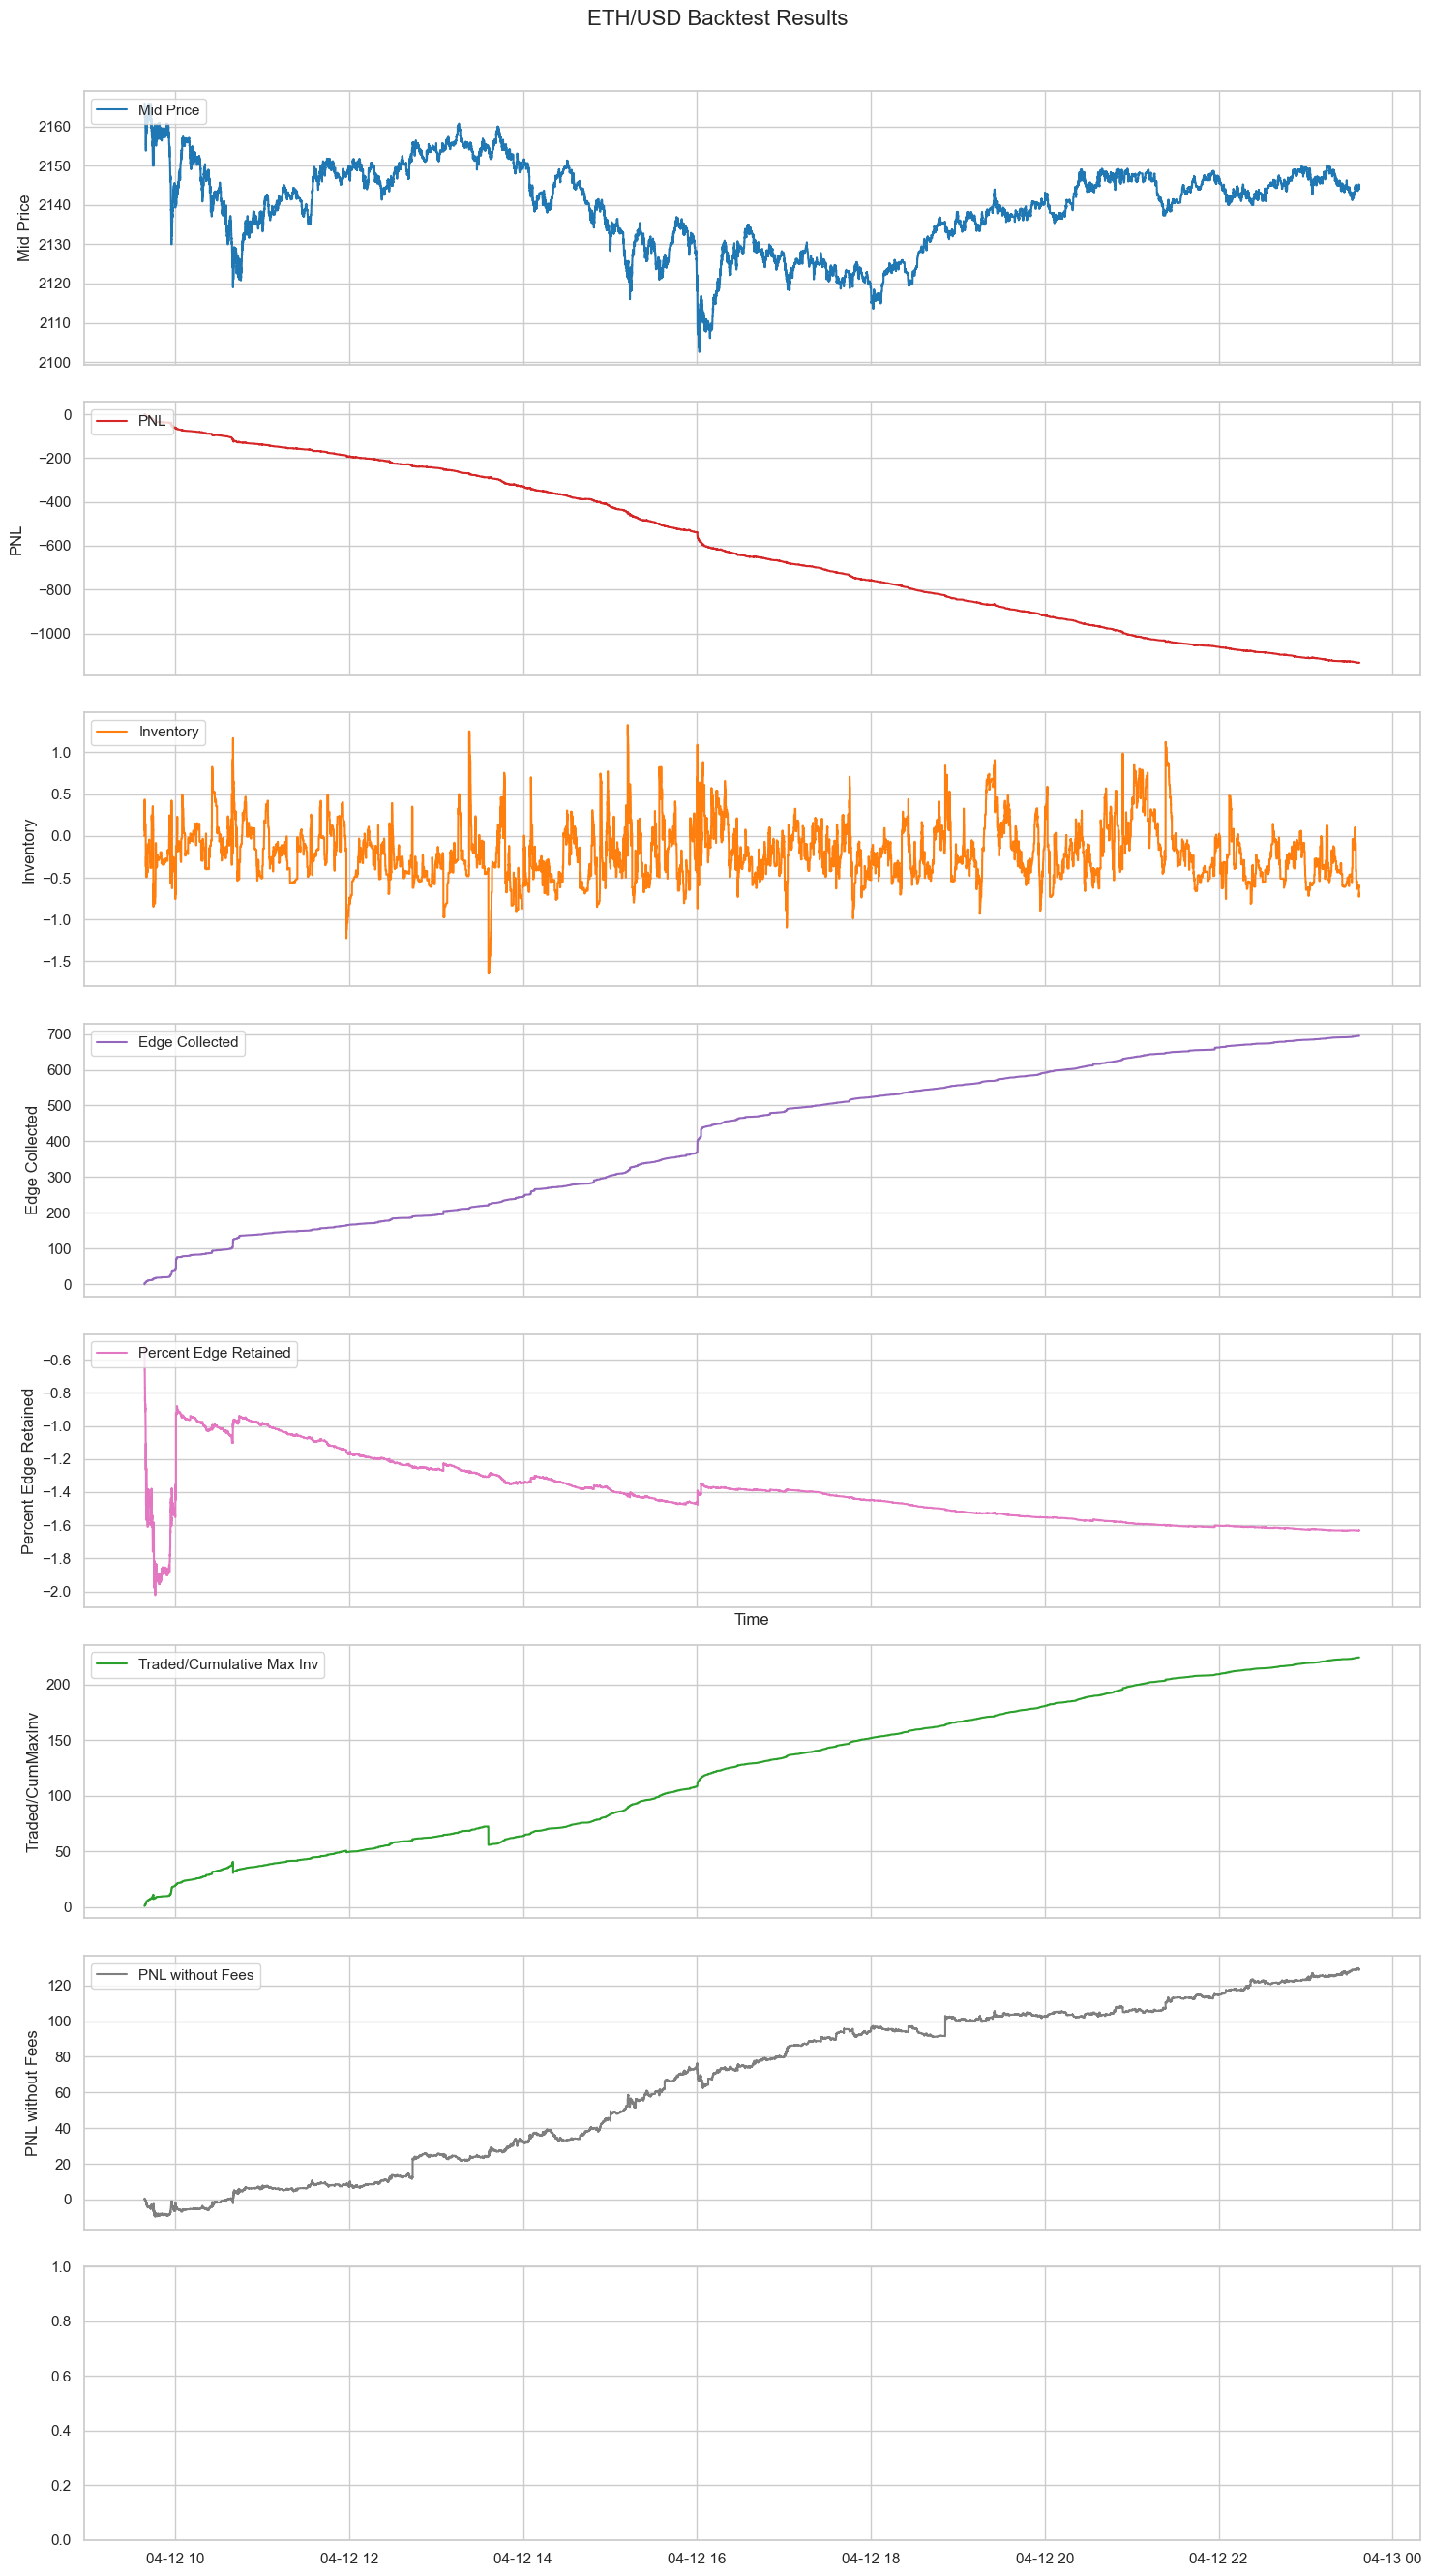

Mean                     -2.25468e-07
Annualized_mean          -7.11037e+00
Volatility                1.53937e-06
Annualized_Volatility     8.64463e-03
Sharpe_Ratio             -1.46468e-01
Annualized_Sharpe        -8.22518e+02
Skewness                 -7.13358e+00
Excess_Kurtosis           1.60747e+02
VaR (0.05)               -2.24409e-06
CVaR (0.05)              -4.68315e-06
Min                      -5.91818e-05
Max                       2.28937e-05
Max Drawdown             -1.12760e-02
Peak                              .5e
Bottom                            .5e
Recovery                          .5e
dtype: object

In [43]:
plot_backtest_results(ETH_USD_adj_tot_backtest_data, title='ETH/USD Backtest Results')
return_data = ETH_USD_adj_reg_backtest_data['PNL'].diff()/100000
display(performance_summary(return_data))

# 11) Analysis

In [49]:

# Assuming ETH_USD_adj_tot_backtest_data, ETH_USD_adj_reg_backtest_data, 
# ETH_BTC_adj_tot_backtest_data, and ETH_BTC_adj_reg_backtest_data are already defined dataframes

# Save each dataframe to a csv file
ETH_USD_adj_tot_backtest_data.to_csv('ETH_USD_adj_tot_backtest_data.csv', index=True)
ETH_USD_adj_reg_backtest_data.to_csv('ETH_USD_adj_reg_backtest_data.csv', index=True)
